In [1]:
import sys
import os

# general
import pandas as pd
import numpy as np
import re
import ot
import multiprocessing as mp

# stats + ML
import scipy.stats as st
from statsmodels.stats.multitest import multipletests as multi
from sklearn import preprocessing
from sklearn import  linear_model
from sklearn.covariance import graphical_lasso
from sklearn.covariance import empirical_covariance
from sklearn.linear_model import LogisticRegression

# clustering
from sklearn.cluster import AgglomerativeClustering

# dimensionality reduction
from sklearn.decomposition import PCA

# metrics
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score

# survival
from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts
from lifelines.statistics import logrank_test

# network
import networkx as nx

# visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2 , venn2_circles
from matplotlib_venn import venn3 , venn3_circles

## Read in and merge data

In [2]:
# reading gene expression data (not included in GitHub repo. Please see supplementary data in manuscript)
with open('data/stellar_gene_expression_qc_filtered.txt') as file:
    gene_expression_stellar= pd.read_csv(file, delimiter='\t')
    

In [3]:
# reading new STELLAR trichrome data with metadata
STELLAR_new_trichrome=pd.read_csv('data/STELLAR_trichrome_new_features2.csv')
STELLAR_new_trichrome=STELLAR_new_trichrome.replace(to_replace=r'Baseline', value='Screening', regex=True)

# list of CRN HIFs
CRN_HIFS=[
       'AREA PROP [[CRN_FOUR] OVER [CRN_ALL_SCORED]] IN [TISSUE]_TRICHROME',
       'AREA PROP [[CRN_ONE] OVER [CRN_ALL_SCORED]] IN [TISSUE]_TRICHROME',
       'AREA PROP [[CRN_THREE] OVER [CRN_ALL_SCORED]] IN [TISSUE]_TRICHROME',
       'AREA PROP [[CRN_TWO] OVER [CRN_ALL_SCORED]] IN [TISSUE]_TRICHROME',
       'AREA PROP [[CRN_ZERO] OVER [CRN_ALL_SCORED]] IN [TISSUE]_TRICHROME']


# CRN scoring
x= STELLAR_new_trichrome[CRN_HIFS]

x.loc[:,('AREA PROP [[CRN_ZERO] OVER [CRN_ALL_SCORED]] IN [TISSUE]_TRICHROME')]=0*x.loc[:,('AREA PROP [[CRN_ZERO] OVER [CRN_ALL_SCORED]] IN [TISSUE]_TRICHROME')]
x.loc[:,('AREA PROP [[CRN_ONE] OVER [CRN_ALL_SCORED]] IN [TISSUE]_TRICHROME')]=1*x.loc[:,('AREA PROP [[CRN_ONE] OVER [CRN_ALL_SCORED]] IN [TISSUE]_TRICHROME')]
x.loc[:,('AREA PROP [[CRN_TWO] OVER [CRN_ALL_SCORED]] IN [TISSUE]_TRICHROME')]=2*x.loc[:,('AREA PROP [[CRN_TWO] OVER [CRN_ALL_SCORED]] IN [TISSUE]_TRICHROME')]
x.loc[:,('AREA PROP [[CRN_THREE] OVER [CRN_ALL_SCORED]] IN [TISSUE]_TRICHROME')]=3*x.loc[:,('AREA PROP [[CRN_THREE] OVER [CRN_ALL_SCORED]] IN [TISSUE]_TRICHROME')]
x.loc[:,('AREA PROP [[CRN_FOUR] OVER [CRN_ALL_SCORED]] IN [TISSUE]_TRICHROME')]=4*x.loc[:,('AREA PROP [[CRN_FOUR] OVER [CRN_ALL_SCORED]] IN [TISSUE]_TRICHROME')]
x.mean(axis=1)/100
STELLAR_new_trichrome['AVERAGE SCORE [[CRN SCORE] OVER [CRN_ALL_SCORED]] IN [TISSUE]_TRICHROME']=x.mean(axis=1)/100

/home/pathai/.conda/envs/clin_acc4/lib/python3.6/site-packages/pandas/core/indexing.py:1783: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [4]:
# reading new STELLAR feature data with metadata
STELLAR_new = pd.read_csv('data/STELLAR_new_with_survival2.csv')

# calculate additional HIFs
STELLAR_new['AREA PROP [[PORTAL INFLAMMATION+INTERFACE] OVER [TISSUE]] IN [TISSUE]_HE']=STELLAR_new['AREA PROP [[PORTAL INFLAMMATION] OVER [TISSUE]] IN [TISSUE]_HE']+STELLAR_new['AREA PROP [[INTERFACE HEPATITIS] OVER [TISSUE]] IN [TISSUE]_HE']
STELLAR_new['AREA (MM2) OF [PORTAL INFLAMMATION+INTERFACE] IN [TISSUE]_HE']= STELLAR_new['AREA (MM2) OF [PORTAL INFLAMMATION] IN [TISSUE]_HE']+STELLAR_new['AREA (MM2) OF [INTERFACE HEPATITIS] IN [TISSUE]_HE']

# merge H&E and trichrome data
STELLAR_new_concat= pd.merge(STELLAR_new, STELLAR_new_trichrome, on=['analysis_visit', 'usubjid'])
STELLAR_new_concat=STELLAR_new_concat.rename(columns={"Split_x":"Split"})

## Functions to calculate statistics

In [5]:
def pearsonr_ci(x,y,alpha=0.05):
    ''' calculate Pearson correlation along with the confidence interval 
    '''

    r, p = st.pearsonr(x,y)
    r_z = np.arctanh(r) #transformation of the correlation coefficient into a Fishers’ Z-score
    se = 1/np.sqrt(x.size-3)
    z = st.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

def squared_diff(x,y):
    return sum((x - y)**2)

def coefficient_of_determination(y,y_pred):
    '''
        calculate coefficient of determination (r-squared)
        
    '''
    
    y_mean = np.mean(y)
    squared_error = squared_diff(y, y_pred)
    squared_error_y_mean = squared_diff(y, y_mean)
    return 1 - (squared_error/squared_error_y_mean)

## Feature Selection (HIFs for gene expression prediction)

In [6]:
# function to get HIFs and gene expression data for samples at given timepoint
def gene_hist_intersection_time(histology_data, gene_expression_data, time, HIF_set): 
    
    
    hist_data_time=histology_data[histology_data['analysis_visit']==time]

    hist_data_filtered=hist_data_time.dropna(axis=0)
    
    analysis_col_MM2='AREA PROP [[BILE DUCT] OVER [TISSUE]] IN [TISSUE]_HE'
    hist_data_filtered=hist_data_filtered.loc[hist_data_filtered.groupby(['usubjid'])[analysis_col_MM2].idxmax()]
    
    
    gene_expression_time= gene_expression_data[gene_expression_data.VISIT== time]
    Samples_hist_ge= list(set(hist_data_filtered['usubjid']) & set(gene_expression_time['USUBJID']))

    gene_expression_analysis = gene_expression_time[gene_expression_time['USUBJID']
                                                          .isin(Samples_hist_ge)] 

    #rearranging stellar hist samples as in gene expression 
    hist_analysis=pd.DataFrame()
    for i, x in enumerate(gene_expression_analysis['USUBJID']):
        hist=hist_data_filtered[hist_data_filtered['usubjid']==x][HIF_set]
        
        hist_analysis=pd.concat([hist_analysis, hist])
        
    return gene_expression_analysis , hist_analysis

In [7]:
# HIFs of interest
HIF_set=[
         'AREA PROP [[BILE DUCT] OVER [TISSUE]] IN [TISSUE]_TRICHROME',
         'AREA PROP [[HEPATOCELLULAR BALLOONING] OVER [TISSUE]] IN [TISSUE]_HE',
         'AREA PROP [[HEPATOCELLULAR SWELLING] OVER [TISSUE]] IN [TISSUE]_HE',
         'AREA PROP [[LOBULAR INFLAMMATION] OVER [TISSUE]] IN [TISSUE]_HE',
         'AREA PROP [[NORMAL HEPATOCYTES] OVER [TISSUE]] IN [TISSUE]_HE',
         'AREA PROP [[PORTAL INFLAMMATION+INTERFACE] OVER [TISSUE]] IN [TISSUE]_HE',
         'AREA PROP [[STEATOSIS] OVER [TISSUE]] IN [TISSUE]_HE',
         'AREA PROP [[STEATOSIS] OVER [HEPATOCELLULAR BALLOONING]] IN [TISSUE]_HE'
        ]
         

In [8]:
# generate data splits for linear regression
STELLAR_new_concat_test=STELLAR_new_concat[STELLAR_new_concat.Split!='train']
STELLAR_new_concat_train=STELLAR_new_concat[STELLAR_new_concat.Split=='train']

gene_expression_analysis_bl_test , hist_analysis_bl_test= gene_hist_intersection_time(STELLAR_new_concat_test, gene_expression_stellar, 'Screening', HIF_set)

gene_expression_analysis_w48_test , hist_analysis_w48_test=gene_hist_intersection_time(STELLAR_new_concat_test, gene_expression_stellar, 'Week 48', HIF_set)


gene_expression_analysis_test= pd.concat([gene_expression_analysis_bl_test, gene_expression_analysis_w48_test]) 
gene_expression_analysis_test=gene_expression_analysis_test.drop(['study_id', 'USUBJID', 'VISIT', 'DV200', 
                                                       'sample_name_simple', 'image_id'], axis=1)
hist_analysis_test= pd.concat([hist_analysis_bl_test, hist_analysis_w48_test])


gene_expression_analysis_bl_train , hist_analysis_bl_train=gene_hist_intersection_time(STELLAR_new_concat_train, gene_expression_stellar, 'Screening', HIF_set)

gene_expression_analysis_w48_train , hist_analysis_w48_train=gene_hist_intersection_time(STELLAR_new_concat_train, gene_expression_stellar, 'Week 48', HIF_set)


gene_expression_analysis_train=pd.concat([gene_expression_analysis_bl_train, gene_expression_analysis_w48_train])
gene_expression_analysis_train=gene_expression_analysis_train.drop(['study_id', 'USUBJID', 'VISIT', 'DV200', 
                                                       'sample_name_simple', 'image_id'], axis=1)
hist_analysis_train=pd.concat([hist_analysis_bl_train, hist_analysis_w48_train])

### Unvariate Modeling (various models shown - Linear Regression, LASSO Linear Regression, Ridge Linear Regression)

10417
[9.64476760e-60 2.96332709e-59 1.57134223e-55 ... 6.29211228e-04
 6.29845513e-04 6.29922667e-04]
Index(['NEO1', 'SEL1L3', 'LAMA2', 'KIRREL1', 'CACNA2D1', 'PACS1', 'ATP8B2',
       'PLXDC2', 'EPHA3', 'SLC12A2',
       ...
       'SERPINA1', 'ATP6V1B1', 'NOP56P3', 'CAPS2', 'MBIP', 'NPM2', 'SLC25A16',
       'VAPB', 'FBN3', 'RCE1'],
      dtype='object', length=10417)


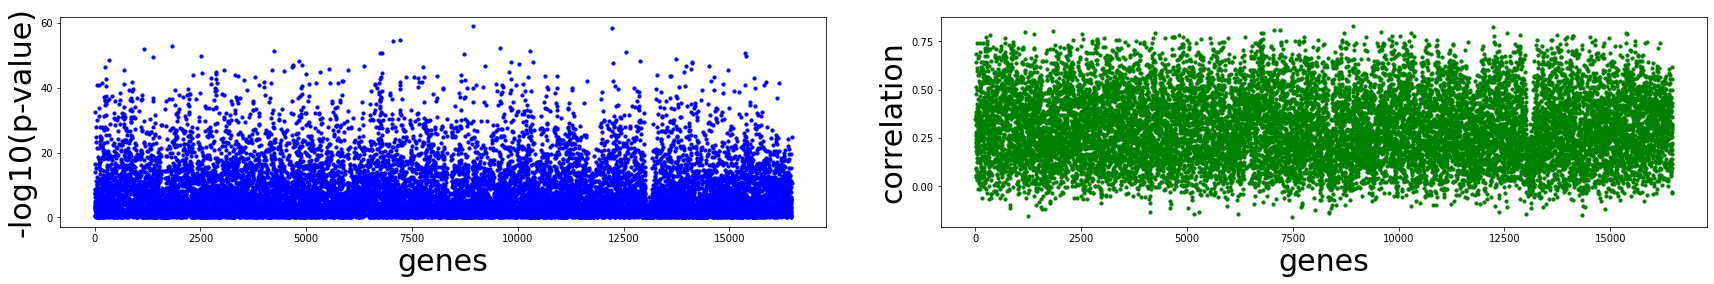

In [9]:
# liner regression for all genes
X_train=hist_analysis_train
X_test=hist_analysis_test

y_train=gene_expression_analysis_train
y_test=gene_expression_analysis_test

corr_genes=[]
pval_corr_genes=[]
r_squared=[]


gene_set=gene_expression_analysis_train.columns

linear_coef=pd.DataFrame()
lasso_coef=pd.DataFrame()
for g in gene_expression_analysis_train.columns:
    y_train=gene_expression_analysis_train[g]
    # Training the Simple Linear Regression model on the Training set
    regr = linear_model.LinearRegression()
    regr.fit(X_train, y_train)
    linear_coef[g]=regr.coef_
    
    lsr = linear_model.Lasso(alpha=0.05, max_iter=10e5)
    lsr.fit(X_train,y_train)
    lasso_coef[g]=lsr.coef_
    # Predicting the Test set results
    y_pred = lsr.predict(X_test)
    
    r, p = st.pearsonr(y_test[g], y_pred) 
    corr_genes.append(r)
    pval_corr_genes.append(p)
    
    rs= coefficient_of_determination(y_test[g],y_pred)
    r_squared.append(rs)
    

_,p_corr_corrected,_,_= multi(pval_corr_genes, method='fdr_bh', alpha=0.1)
n_genes=np.shape(np.where(p_corr_corrected < 0.001))[1]
print(n_genes)
 
argp_corr= np.argsort(pval_corr_genes)[0:n_genes]
print(np.array(pval_corr_genes)[argp_corr])
gene_selected_all= gene_set[argp_corr] 


r_squared_selected=np.array(r_squared)[argp_corr]
corr_genes_selected=np.array(corr_genes)[argp_corr]

print(gene_set[argp_corr]) 

pval_corr_log= -np.log10(pval_corr_genes)
fig, axs = plt.subplots(1, 2, figsize=(25, 5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .1, wspace=.001)
axs = axs.ravel()

axs[0].scatter(x= list(range(np.shape(pval_corr_genes)[0])), y=pval_corr_log, s=10, c='b')
axs[0].set_xlabel('genes', fontsize=30)
axs[0].set_ylabel('-log10(p-value)', fontsize=30)

axs[1].scatter(x= list(range(np.shape(corr_genes)[0])), y= corr_genes, s=10, c='g')

axs[1].set_xlabel('genes', fontsize=30)
axs[1].set_ylabel('correlation', fontsize=30)
    
plt.tight_layout(pad=5.0)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)    

### Highlighting effect of penalization for JAG1 gene

training score: 0.6329585010239485
test score:  0.6326740033144277
Mean squared error: 0.19
Coefficient of determination: 0.63
ridge training score for alpha=0.01: 0.6329585009142835
ridge test score for alpha =0.01:  0.6326745700932224
lasso training score for alpha=0.01: 0.6224555565243779
lasso test score for alpha =0.01:  0.6255519580090874
number of features used: for alpha =0.01: 6


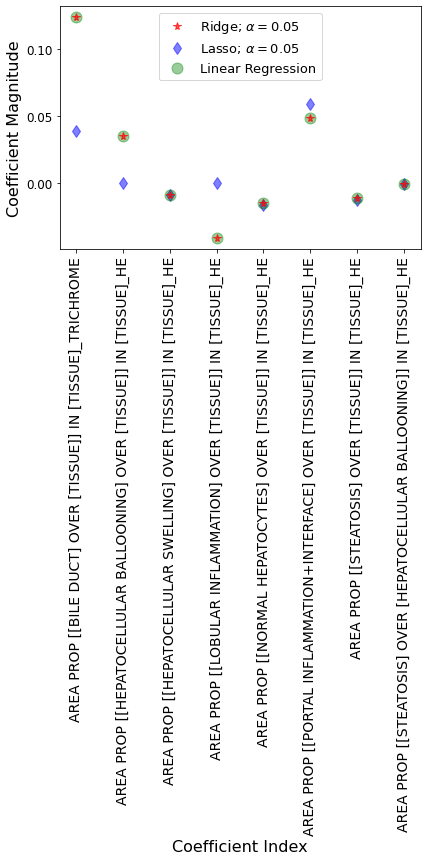

In [10]:
# example predicting just 1 gene to examine effect of penalization on coefficient
X_train=hist_analysis_train
X_test=hist_analysis_test

y_train=gene_expression_analysis_train['JAG1']
y_test=gene_expression_analysis_test['JAG1']


#linear regression model
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)

# higher the alpha value, more restriction on the coefficients; low alpha -> more generalization,


#ridge model
rr = linear_model.Ridge(alpha=0.05) 
rr.fit(X_train, y_train)

#lasso model

lsr = linear_model.Lasso(alpha=0.05, max_iter=10e5)
lsr.fit(X_train,y_train)



train_score=lr.score(X_train, y_train)
test_score=lr.score(X_test, y_test)

print ("training score:", train_score )
print ("test score: ", test_score)



y_pred=lr.predict(X_test)

print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))



Ridge_train_score = rr.score(X_train,y_train)
Ridge_test_score = rr.score(X_test, y_test)

print ("ridge training score for alpha=0.01:", Ridge_train_score )
print ("ridge test score for alpha =0.01: ", Ridge_test_score)



lasso_train_score=lsr.score(X_train,y_train)
lasso_test_score=lsr.score(X_test,y_test)
coeff_used_lsr = np.sum(lsr.coef_!=0)

print ("lasso training score for alpha=0.01:", lasso_train_score )
print ("lasso test score for alpha =0.01: ", lasso_test_score)
print ("number of features used: for alpha =0.01:", coeff_used_lsr)


plt.plot(rr.coef_,alpha=0.7,linestyle='none',marker='*',markersize=8,color='red',label=r'Ridge; $\alpha = 0.05$',zorder=7) 
plt.plot(lsr.coef_,alpha=0.5,linestyle='none',marker='d',markersize=9,color='blue',label=r'Lasso; $\alpha = 0.05$') 
plt.plot(lr.coef_,alpha=0.4,linestyle='none',marker='o',markersize=11,color='green',label='Linear Regression')
plt.xlabel('Coefficient Index',fontsize=16)
plt.ylabel('Coefficient Magnitude',fontsize=16)
plt.legend(fontsize=13,loc='upper center')
plt.tight_layout(pad=0.01)
plt.xticks(np.arange(0,np.shape(HIF_set)[0]),HIF_set, rotation=90, fontsize=14)
plt.yticks(fontsize=12)
plt.rcParams["figure.figsize"] = [8,6]
plt.show()

### Distribution of coefficients for HIF associations with genes for unpenalized model (top genes in this example defined here as R^2 > 0.5)

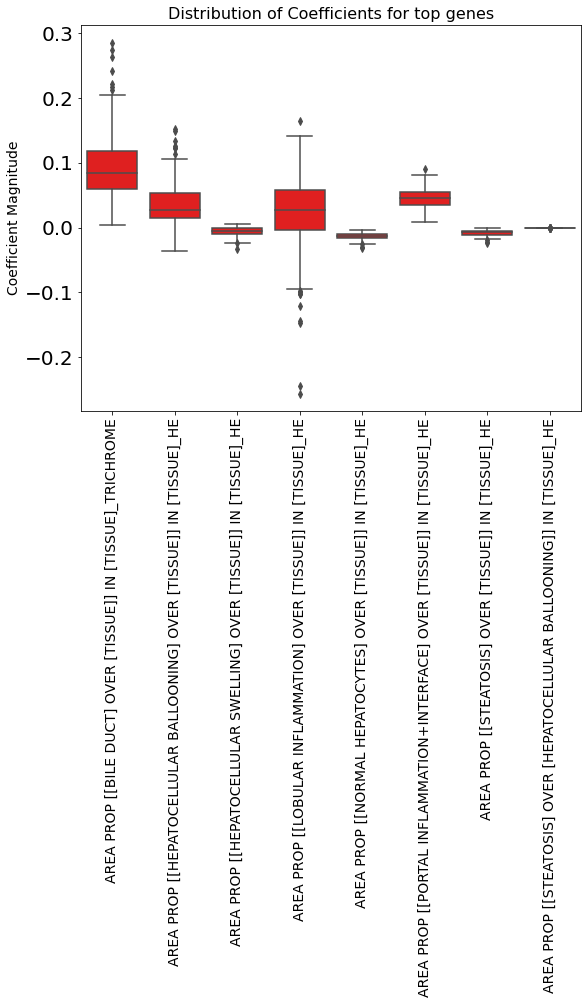

In [11]:
# distribution of coefficients 
n_genes=np.shape(np.where(r_squared_selected>0.5))[1]
n_hifs=np.shape(HIF_set)[0]
linear_coef_select=linear_coef[gene_selected_all[np.where(r_squared_selected>0.5)]]


Coef_features=np.array(linear_coef_select)
Coef_features=np.reshape(Coef_features, (n_genes*n_hifs,1))
Coef_features=[x[0] for x in Coef_features]


HIFs_features=[]
for i in range(n_hifs):
    y_i=np.zeros(n_genes)+i
    HIFs_features.append(y_i)
    
HIFs_features=np.reshape(HIFs_features, (n_genes*n_hifs,1))
HIFs_features=[int(x[0]) for x in HIFs_features]


features= ["Coeff", "HIFs"]
d = {features[0]: list(np.squeeze(Coef_features)), features[1]: list(HIFs_features)}
df = pd.DataFrame(data=d)


sns.boxplot(x=features[1],y=features[0],data=df,color='r', order=list(np.arange(n_hifs)));
plt.xlabel('')

plt.ylabel('Coefficient Magnitude', fontsize=14)
plt.title('Distribution of Coefficients for top genes', fontsize=16)
plt.tight_layout(pad=0.1)
plt.xticks(np.arange(0,np.shape(HIF_set)[0]),HIF_set, rotation=90, fontsize=14)


plt.rcParams["figure.figsize"] = [8,6]
plt.rc('ytick', labelsize=20)

plt.savefig('Coefficien_Distribution.png', dpi=300, bbox_inches = 'tight')

### Distribution of coefficients for HIF associations with genes for LASSO model (top genes in this example defined here as R^2 > 0.5)

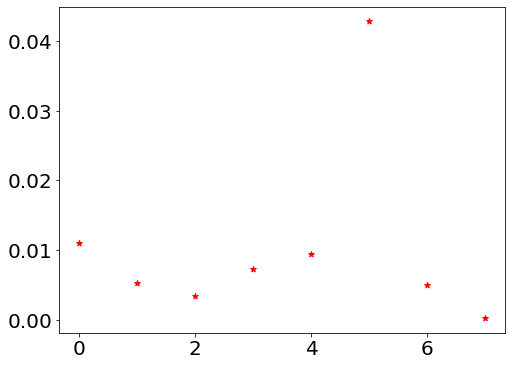

\begin{tabular}{rl}
\toprule
   &                              Histological Features \\
\midrule
 1 &  AREA PROP [[PORTAL INFLAMMATION+INTERFACE] OVE... \\
 2 &  AREA PROP [[BILE DUCT] OVER [TISSUE]] IN [TISS... \\
 3 &  AREA PROP [[NORMAL HEPATOCYTES] OVER [TISSUE]]... \\
 4 &  AREA PROP [[LOBULAR INFLAMMATION] OVER [TISSUE... \\
 5 &  AREA PROP [[HEPATOCELLULAR BALLOONING] OVER [T... \\
 6 &  AREA PROP [[STEATOSIS] OVER [TISSUE]] IN [TISS... \\
 7 &  AREA PROP [[HEPATOCELLULAR SWELLING] OVER [TIS... \\
 8 &  AREA PROP [[STEATOSIS] OVER [HEPATOCELLULAR BA... \\
\bottomrule
\end{tabular}



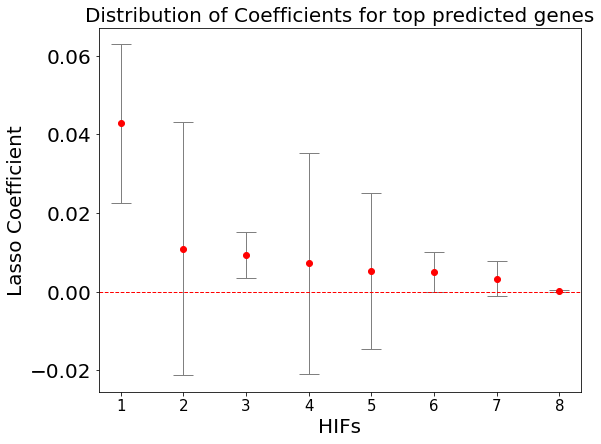

In [12]:
n_genes=np.shape(np.where(corr_genes_selected>0.5))[1]
n_hifs=np.shape(HIF_set)[0]
linear_coef_select=abs(lasso_coef[gene_selected_all[np.where(corr_genes_selected>0.5)]])

nonzero_linear_coef=pd.DataFrame()
for i in linear_coef_select.index:
    for j in linear_coef_select.columns:
        nonzero_linear_coef.loc[i,j]=int(linear_coef_select.loc[i,j]!=0)


Coef_features=np.array(linear_coef_select)
Coef_features=np.reshape(Coef_features, (n_genes*n_hifs,1))
Coef_features=[x[0] for x in Coef_features]


HIFs_features=[]
for i in range(n_hifs):
    y_i=np.zeros(n_genes)+i
    HIFs_features.append(y_i)
    
HIFs_features=np.reshape(HIFs_features, (n_genes*n_hifs,1))
HIFs_features=[int(x[0]) for x in HIFs_features]


features= ["Coeff", "HIFs"]
d = {features[0]: list(np.squeeze(Coef_features)), features[1]: list(HIFs_features)}
df = pd.DataFrame(data=d)

x=[]
for i in range(np.shape(HIF_set)[0]):
    z=df[df.HIFs==i].mean(0)[0]
    x.append(z)
    
plt.scatter(range(len(x)),x, c='r',marker="*")
#plt.axhline(y=0, color='r', linestyle='-')


plt.savefig('Coefficien_Distribution.png', dpi=300, bbox_inches = 'tight')

plt.show()


x=[]
sd=[]
for i in range(np.shape(HIF_set)[0]):
    z=df[df.HIFs==i].mean(0)[0]
    s=df[df.HIFs==i].std(0)[0]
    x.append(z)
    sd.append(s)
mn=np.sort(x)[::-1]  
arg=np.argsort(x)[::-1]
sd=np.array(sd)[arg]

plt.errorbar(np.arange(0,np.shape(HIF_set)[0]), np.array(mn), yerr=np.array(sd), color='r',ecolor='gray',elinewidth=1, capsize=10,fmt='o')

#plt.scatter(range(len(x)),mn)
plt.axhline(y=0, color='r', linestyle='--', linewidth=1)
plt.xticks(np.arange(0,np.shape(HIF_set)[0]),range(1,np.shape(HIF_set)[0]+1), fontsize=15);

plt.xlabel('HIFs', fontsize=20)

plt.ylabel('Lasso Coefficient', fontsize=20)
plt.title('Distribution of Coefficients for top predicted genes', fontsize=20)
plt.tight_layout(pad=0.1)
plt.savefig('Coefficien_Distribution2.png', dpi=300, bbox_inches = 'tight')


 
df=pd.DataFrame()
df.insert(0,'Histological Features', [HIF_set[i] for i in arg])
df.insert(0,'',range(1,np.shape(HIF_set)[0]+1))
print(df.to_latex(index=False))


## Predict CRN Score from GE

In [13]:
STELLAR_new_concat_test=STELLAR_new_concat[STELLAR_new_concat.Split!='train']

STELLAR_new_concat_train=STELLAR_new_concat[STELLAR_new_concat.Split=='train']

gene_expression_analysis_bl_test , hist_analysis_bl_test= gene_hist_intersection_time(STELLAR_new_concat_test, gene_expression_stellar, 'Screening', ['fibsg_bl'])
hist_analysis_bl_test=hist_analysis_bl_test.rename(columns={'fibsg_bl':'fibsg'})
gene_expression_analysis_w48_test , hist_analysis_w48_test=gene_hist_intersection_time(STELLAR_new_concat_test, gene_expression_stellar, 'Week 48', ['fibsg_w48'])
hist_analysis_w48_test=hist_analysis_w48_test.rename(columns={'fibsg_w48':'fibsg'})

gene_expression_analysis_test= pd.concat([gene_expression_analysis_bl_test, gene_expression_analysis_w48_test], ignore_index=True) 
gene_expression_analysis_test=gene_expression_analysis_test.drop(['study_id', 'USUBJID', 'VISIT', 'DV200', 
                                                       'sample_name_simple', 'image_id'], axis=1)
hist_analysis_test= pd.concat([hist_analysis_bl_test, hist_analysis_w48_test], ignore_index=True)


gene_expression_analysis_bl_train , hist_analysis_bl_train=gene_hist_intersection_time(STELLAR_new_concat_train, gene_expression_stellar, 'Screening', ['fibsg_bl'])
hist_analysis_bl_train=hist_analysis_bl_train.rename(columns={'fibsg_bl':'fibsg'})
gene_expression_analysis_w48_train , hist_analysis_w48_train=gene_hist_intersection_time(STELLAR_new_concat_train, gene_expression_stellar, 'Week 48', ['fibsg_w48'])
hist_analysis_w48_train=hist_analysis_w48_train.rename(columns={'fibsg_w48':'fibsg'})

gene_expression_analysis_train=pd.concat([gene_expression_analysis_bl_train, gene_expression_analysis_w48_train], ignore_index=True)
gene_expression_analysis_train=gene_expression_analysis_train.drop(['study_id', 'USUBJID', 'VISIT', 'DV200', 
                                                       'sample_name_simple', 'image_id'], axis=1)
hist_analysis_train=pd.concat([hist_analysis_bl_train, hist_analysis_w48_train], ignore_index=True)

#remove CRN 0,1,2
drop_index_train=list(hist_analysis_train[hist_analysis_train.fibsg.isin([0,1,2])].index)
drop_index_test=list(hist_analysis_test[hist_analysis_test.fibsg.isin([0,1,2])].index)

gene_expression_analysis_train=gene_expression_analysis_train.drop(drop_index_train)
gene_expression_analysis_test=gene_expression_analysis_test.drop(drop_index_test)

hist_analysis_train=hist_analysis_train.drop(drop_index_train)
hist_analysis_test=hist_analysis_test.drop(drop_index_test)

In [14]:
# train and obtain test set predictions for logistic regression model
def logistic_pred(n, gene_set1, hist_analysis_train,hist_analysis_test,gene_expression_analysis_train,gene_expression_analysis_test):
    A= gene_set1[0:n]

    y_train=hist_analysis_train
    y_test=hist_analysis_test

    X_train=gene_expression_analysis_train[A]
    X_test=gene_expression_analysis_test[A]

    log_reg = LogisticRegression(max_iter=100000).fit(X_train, list(y_train.fibsg))
    y_pred=log_reg.predict(X_test)

    y_prob=log_reg.predict_log_proba(X_test)
    return y_pred


In [15]:
# Creating a function to report confusion metrics
def confusion_metrics (conf_matrix):
# save confusion matrix and slice into four pieces

    TN, FP, FN, TP = conf_matrix.ravel()
    print('True Positives:', TP)
    print('True Negatives:', TN)
    print('False Positives:', FP)
    print('False Negatives:', FN)
    
    # calculate accuracy
    conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
    
    # calculate mis-classification
    conf_misclassification = 1- conf_accuracy
    
    # calculate the sensitivity
    conf_sensitivity = (TP / float(TP + FN))
    # calculate the specificity
    conf_specificity = (TN / float(TN + FP))
    
    # calculate precision
    conf_precision = (TN / float(TN + FP))
    # calculate f_1 score
    conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
    print('-'*50)
    print(f'Accuracy: {round(conf_accuracy,2)}') 
    print(f'Mis-Classification: {round(conf_misclassification,2)}') 
    print(f'Sensitivity: {round(conf_sensitivity,2)}') 
    print(f'Specificity: {round(conf_specificity,2)}') 
    print(f'Precision: {round(conf_precision,2)}')
    print(f'f_1 Score: {round(conf_f1,2)}')
    
    
def F1_conf_matrix(conf_matrix):
# save confusion matrix and slice into four pieces

    TN, FP, FN, TP = conf_matrix.ravel()

    # calculate accuracy
    conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
    
    # calculate mis-classification
    conf_misclassification = 1- conf_accuracy
    
    # calculate the sensitivity
    conf_sensitivity = (TP / float(TP + FN))
    # calculate the specificity
    conf_specificity = (TN / float(TN + FP))
    
    # calculate precision
    conf_precision = (TN / float(TN + FP))
    # calculate f_1 score
    conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))

    return conf_precision    

In [16]:
analysis_col2 = 'AREA PROP [[PORTAL INFLAMMATION] OVER [TISSUE]] IN [TISSUE]_HE'
analysis_col3= 'AREA PROP [[FIBROSIS] OVER [TISSUE]] IN [TISSUE]_TRICHROME'

n=1500
gene_set2 = pd.read_csv('data/gene_selected_new2_'+ analysis_col2+'.csv')
B= set(gene_set2['0'][0:n])
gene_set3= pd.read_csv('data/gene_selected_new2_'+ analysis_col3+'.csv')
C= set(gene_set3['0'][0:n])

gene_set1=list(B&C)
gene_set1= ['VIM', 'PDGFRA', 'CLSTN1', 'JAG1', 'VWF']

In [17]:
y_train=hist_analysis_train
y_test=hist_analysis_test

X_train=gene_expression_analysis_train
X_test=gene_expression_analysis_test

kappa=dict()
F1=dict()
for n in [1100, 900, 500, 100]:
    y_pred= logistic_pred(n, gene_set1, hist_analysis_train,hist_analysis_test,gene_expression_analysis_train,gene_expression_analysis_test)
    kappa[n]= cohen_kappa_score(y_test, y_pred)
    conf_mat=confusion_matrix(y_pred, y_test)
    F1[n]= F1_conf_matrix(conf_mat)
    

In [18]:
pd.DataFrame.from_dict(F1, orient='index', columns=['F1'])

,F1
1100,0.813953
900,0.813953
500,0.813953
100,0.813953


In [19]:
pd.DataFrame.from_dict(kappa, orient='index', columns=['Kappa'])

,Kappa
1100,0.580406
900,0.580406
500,0.580406
100,0.580406


In [20]:
confusion_metrics (conf_mat)

True Positives: 104
True Negatives: 70
False Positives: 16
False Negatives: 29
--------------------------------------------------
Accuracy: 0.79
Mis-Classification: 0.21
Sensitivity: 0.78
Specificity: 0.81
Precision: 0.81
f_1 Score: 0.8


## Correlation Analysis

In [21]:
# intersect gene expression with HIFs data for one time point
def gene_hist_intersection_time(analysis_col,analysis_col_MM2, histology_data, gene_expression_data, time):
    
    
    hist_data_time=histology_data[histology_data['analysis_visit']==time]
    hist_data_time= hist_data_time.dropna(subset=[analysis_col])
        
        
    # drop repeated data based on area of usable tissue (MM2)
    hist_data_filtered=hist_data_time.loc[hist_data_time.groupby(['usubjid'])[analysis_col_MM2].idxmax()]
    
    
    
    gene_expression_time= gene_expression_data[gene_expression_data.VISIT== time]

    Samples_hist_ge= list(set(hist_data_filtered['usubjid']) & set(gene_expression_time['USUBJID']))

    gene_expression_analysis = gene_expression_time[gene_expression_time['USUBJID']
                                                          .isin(Samples_hist_ge)] 
    
    
    #rearranging stellar hist samples as in gene expression 
    hist_analysis=[]
    for i, x in enumerate(gene_expression_analysis['USUBJID']):
        hist = list(hist_data_filtered[hist_data_filtered['usubjid']==x][analysis_col])
        hist_analysis.append(hist)
        
    return gene_expression_analysis , hist_analysis






def gene_hist_intersection_all_time(analysis_col, analysis_col_MM2, histology_data, gene_expression_data):
    

    
    gene_expression_analysis1 , hist_analysis1 = gene_hist_intersection_time(analysis_col,analysis_col_MM2, histology_data, 
                                                                             gene_expression_data, 'Screening')
    
    gene_expression_analysis2 , hist_analysis2 = gene_hist_intersection_time(analysis_col, analysis_col_MM2, histology_data, 
                                                                             gene_expression_data, 'Week 48')
    

    hist_all_=hist_analysis1 
    hist_all_.extend(hist_analysis2) 
    hist_all_analysis=[i[0] for i in hist_all_]


    gene_expression_analysis= pd.concat([gene_expression_analysis1, gene_expression_analysis2])  

    gene_expression_analysis=gene_expression_analysis.drop(['study_id', 'USUBJID', 'VISIT', 'DV200', 
                                                       'sample_name_simple', 'image_id'], axis=1)


    return gene_expression_analysis , hist_all_analysis


def top_correlated_genes(n_genes, analysis_col, analysis_col_MM2, histology_data, gene_expression_data):
    gene_expression_analysis , Stellar_all_analysis= gene_hist_intersection_all_time(analysis_col, analysis_col_MM2,histology_data, gene_expression_data)
    gene_set= gene_expression_analysis.columns

    corr_genes=[]
    pval_corr_genes=[]
    for i, g in enumerate(gene_set):
        r, p = st.spearmanr(gene_expression_analysis[g], Stellar_all_analysis)
        corr_genes.append(r)
        pval_corr_genes.append(p)
    
    _,p_corr_corrected,_,_= multi(pval_corr_genes, method='Bonferroni',alpha=0.1)
    argp_corr= np.argsort(p_corr_corrected)[0:n_genes]
    gene_selected_all= gene_set[argp_corr] 
    pval_corr_sorted= p_corr_corrected[argp_corr]
    corr_genes_sorted= np.array(corr_genes)[argp_corr]
    return gene_selected_all, pval_corr_sorted, corr_genes_sorted
     

/home/pathai/.conda/envs/clin_acc4/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]


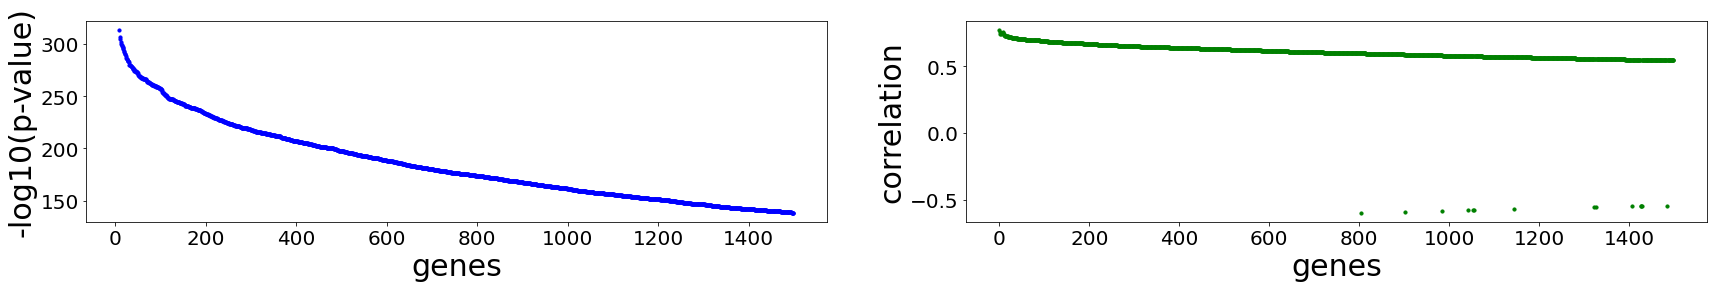

In [22]:
n_genes=1500

analysis_col = 'AREA PROP [[PORTAL INFLAMMATION] OVER [TISSUE]] IN [TISSUE]_HE'
analysis_col_MM2= 'AREA (MM2) OF [PORTAL INFLAMMATION] IN [TISSUE]_HE'


gene_selected_all, pval_corr_genes, corr_genes=top_correlated_genes(n_genes, analysis_col,analysis_col_MM2, STELLAR_new_concat, gene_expression_stellar)


pd.DataFrame(gene_selected_all).to_csv('gene_selected_new2_'+ analysis_col+'.csv', index_label='Genes', index=False) 


pval_corr_log= -np.log10(pval_corr_genes)
fig, axs = plt.subplots(1, 2, figsize=(25, 5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .1, wspace=.001)
axs = axs.ravel()

axs[0].scatter(x= list(range(np.shape(pval_corr_genes)[0])), y=pval_corr_log, s=10, c='b')
axs[0].set_xlabel('genes', fontsize=30)
axs[0].set_ylabel('-log10(p-value)', fontsize=30)

axs[1].scatter(x= list(range(np.shape(corr_genes)[0])), y= corr_genes, s=10, c='g')

axs[1].set_xlabel('genes', fontsize=30)
axs[1].set_ylabel('correlation', fontsize=30)
    
plt.tight_layout(pad=5.0)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)

In [23]:
analysis_col= 'AREA PROP [[FIBROSIS] OVER [TISSUE]] IN [TISSUE]_TRICHROME'
analysis_col_MM2= 'AREA (MM2) OF [FIBROSIS] IN [TISSUE]_TRICHROME'

analysis_col= 'AREA PROP [[BILE DUCT] OVER [TISSUE]] IN [TISSUE]_TRICHROME'
analysis_col_MM2=  'AREA (MM2) OF [BILE DUCT] IN [TISSUE]_TRICHROME'

analysis_col = 'AREA PROP [[PORTAL INFLAMMATION] OVER [TISSUE]] IN [TISSUE]_HE'
analysis_col_MM2= 'AREA (MM2) OF [PORTAL INFLAMMATION] IN [TISSUE]_HE'

gene_expression_analysis , Stellar_all_analysis= gene_hist_intersection_all_time(analysis_col, analysis_col_MM2,STELLAR_new_concat, gene_expression_stellar)
gene_set= gene_expression_analysis.columns


r, p = st.spearmanr(gene_expression_analysis['VWF'], Stellar_all_analysis)

print(r)

0.6738414923915027


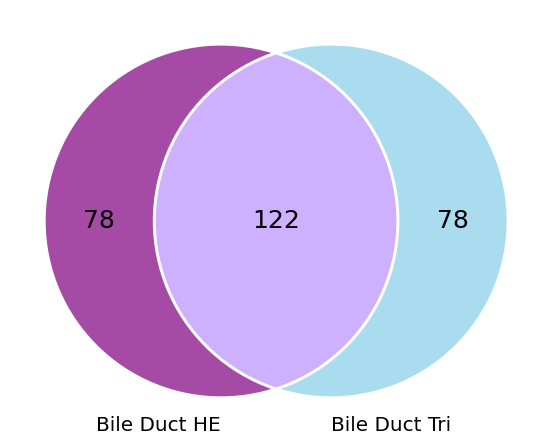

In [24]:
analysis_col2 ='AREA PROP [[BILE DUCT] OVER [TISSUE]] IN [TISSUE]_HE'

analysis_col= 'AREA PROP [[INTERFACE HEPATITIS] OVER [TISSUE]] IN [TISSUE]_HE'
analysis_col1 = 'AREA PROP [[BILE DUCT] OVER [TISSUE]] IN [TISSUE]_TRICHROME'
analysis_col3= 'AREA PROP [[HEPATOCELLULAR BALLOONING] OVER [TISSUE]] IN [TISSUE]_HE'
analysis_col4= 'AREA PROP [[LOBULAR INFLAMMATION] OVER [TISSUE]] IN [TISSUE]_HE'


analysis_col1 = 'AREA PROP [[BILE DUCT] OVER [TISSUE]] IN [TISSUE]_TRICHROME'
analysis_col2 = 'AREA PROP [[PORTAL INFLAMMATION] OVER [TISSUE]] IN [TISSUE]_HE'

gene_set1 = pd.read_csv('data/gene_selected_new2_'+ analysis_col1+'.csv')
A= set(gene_set1['0'][0:200])
gene_set2 = pd.read_csv('data/gene_selected_new2_'+ analysis_col2+'.csv')
B= set(gene_set2['0'][0:200])
 

c1= venn2([A,B], set_labels = ('Bile Duct HE','Bile Duct Tri'), set_colors=('purple','skyblue'), alpha=0.7);
for c in c1.set_labels:
    c.set_fontsize(20)
for c in c1.subset_labels:
    c.set_fontsize(25)
c2= venn2_circles([A,B],linestyle='solid', linewidth=0.1, color='w')
c2[0].set_lw(3.0)
c2[1].set_lw(3.0)
plt.tight_layout(pad=0.001)

#plt.show()

plt.savefig('venn_diag_10.png', dpi=300)

### Example getting counts for Figure 4A

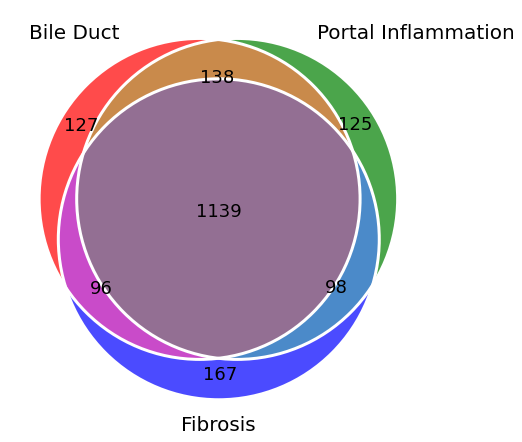

In [25]:
analysis_col1 = 'AREA PROP [[BILE DUCT] OVER [TISSUE]] IN [TISSUE]_TRICHROME'
analysis_col2 = 'AREA PROP [[PORTAL INFLAMMATION] OVER [TISSUE]] IN [TISSUE]_HE'
analysis_col3= 'AREA PROP [[FIBROSIS] OVER [TISSUE]] IN [TISSUE]_TRICHROME'



n=1500
gene_set1 = pd.read_csv('data/gene_selected_new2_'+ analysis_col1+'.csv')
A= set(gene_set1['0'][0:n])
gene_set2 = pd.read_csv('data/gene_selected_new2_'+ analysis_col2+'.csv')
B= set(gene_set2['0'][0:n])
gene_set3= pd.read_csv('data/gene_selected_new2_'+ analysis_col3+'.csv')
C= set(gene_set3['0'][0:n])


c1=venn3([A,B,C], alpha = 0.7, set_labels = ('Bile Duct', 'Portal Inflammation', 
                                          'Fibrosis'))

c= venn3_circles([A,B,C], 
                 linestyle='solid', linewidth=2, color='w')

for t in c1.set_labels: t.set_fontsize(20)
for t in c1.subset_labels: t.set_fontsize(18)   
    
c[0].set_lw(3.0)
c[1].set_lw(3.0)
c[2].set_lw(3.0)
#c[2].set_ls('dashed')
#plt.show()
plt.tight_layout(pad=0.001)
plt.savefig('venn_diag_feature2.png', dpi=300)

## Concodrance of GE Clusters with Histologic features

<AxesSubplot:xlabel='fbstage', ylabel='HC'>

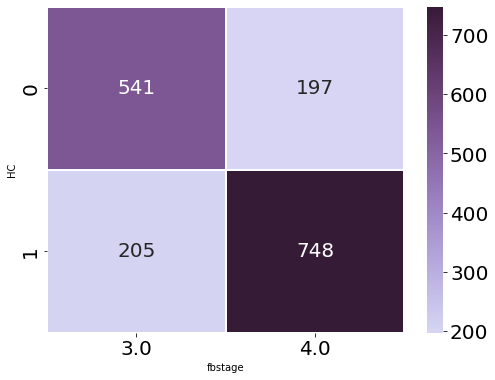

In [27]:
# Confusion matrix of GE clusters and fibrosis scores
analysis_col1 = 'AREA PROP [[BILE DUCT] OVER [TISSUE]] IN [TISSUE]_TRICHROME'
analysis_col2 = 'AREA PROP [[PORTAL INFLAMMATION] OVER [TISSUE]] IN [TISSUE]_HE'
analysis_col3= 'AREA PROP [[FIBROSIS] OVER [TISSUE]] IN [TISSUE]_TRICHROME'
analysis_col4= 'fibsg_bl'
analysis_col5= 'fibsg_w48'


n=200
gene_set1 = pd.read_csv('data/gene_selected_new2_'+ analysis_col1+'.csv')
A= set(gene_set1['0'][0:n])
gene_set2 = pd.read_csv('data/gene_selected_new2_'+ analysis_col2+'.csv')
B= set(gene_set2['0'][0:n])
gene_set3= pd.read_csv('data/gene_selected_new2_'+ analysis_col3+'.csv')
C= set(gene_set3['0'][0:n])


gene_selected= list(set(gene_set1['0'][0:n]) & set(gene_set2['0'][0:n])& set(gene_set3['0'][0:n]))


analysis_col=[analysis_col1, analysis_col2, analysis_col3, analysis_col4, analysis_col5]

analysis_col_MM2='AREA (MM2) OF [PORTAL INFLAMMATION] IN [TISSUE]_HE'


gene_selected.append('USUBJID')

STELLAR=STELLAR_new_concat

Stellar_new_bl=STELLAR[STELLAR['analysis_visit']=='Screening']
Stellar_new_bl=Stellar_new_bl.loc[Stellar_new_bl.groupby(['usubjid'])[analysis_col_MM2].idxmax()]


Stellar_new_w48=STELLAR[STELLAR['analysis_visit']=='Week 48']
Stellar_new_w48=Stellar_new_w48.loc[Stellar_new_w48.groupby(['usubjid'])[analysis_col_MM2].idxmax()]

### intersection of Stellar for analysis_col with BL GE
Stellar_filtered_bl= Stellar_new_bl.dropna(subset=analysis_col)
gene_expression_stellar_before= gene_expression_stellar[gene_expression_stellar.VISIT== 'Screening']


#samples with both hist and gene expression data (BL)
Samples_Stellar_ge1= list(set(Stellar_filtered_bl['usubjid']) & set(gene_expression_stellar_before['USUBJID']))

Stellar_all1 = Stellar_filtered_bl[Stellar_filtered_bl['usubjid'].isin(Samples_Stellar_ge1)][['usubjid']+ analysis_col] 
Stellar_all1=Stellar_all1.rename(columns={"usubjid": "USUBJID"})
gene_expression_analysis1 = gene_expression_stellar_before[gene_expression_stellar_before['USUBJID']
                                                          .isin(Samples_Stellar_ge1)] 
gene_expression_analysis1=gene_expression_analysis1[gene_selected]

#rearranging stellar hist samples as in gene expression 
hist_gene_BL=Stellar_all1.merge(gene_expression_analysis1, how='inner', on='USUBJID')
hist_gene_BL=hist_gene_BL.rename(columns={'fibsg_bl': 'fibsg'})    
    
    
### intersection of Stellar for analysis_col with W48 GE
Stellar_filtered_w48= Stellar_new_w48.dropna(subset=analysis_col)
gene_expression_stellar_after= gene_expression_stellar[gene_expression_stellar.VISIT== 'Week 48']


#samples with both hist and gene expression data (W48)
Samples_Stellar_ge2= list(set(Stellar_filtered_w48['usubjid']) & set(gene_expression_stellar_after['USUBJID']))

Stellar_all2 = Stellar_filtered_w48[Stellar_filtered_w48['usubjid'].isin(Samples_Stellar_ge2)][['usubjid']+ analysis_col] 
Stellar_all2=Stellar_all2.rename(columns={"usubjid": "USUBJID"})
gene_expression_analysis2 = gene_expression_stellar_after[gene_expression_stellar_after['USUBJID']
                                                          .isin(Samples_Stellar_ge2)] 

gene_expression_analysis2=gene_expression_analysis2[gene_selected]
#rearranging stellar hist samples as in gene expression 
hist_gene_W48=Stellar_all2.merge(gene_expression_analysis2, how='inner', on='USUBJID')
hist_gene_W48=hist_gene_W48.rename(columns={'fibsg_w48': 'fibsg'})       


gene_expression_analysis=[]
hist_gene_expression_selected=[]
hist_gene_expression_selected= pd.concat([hist_gene_BL, hist_gene_W48], axis=0, ignore_index=True)   
hist_gene_expression_selected=hist_gene_expression_selected.drop(['USUBJID'], axis=1)



hist_gene_expression_selected=hist_gene_expression_selected[~(hist_gene_expression_selected['fibsg'].isin([0.0, 1.0, 2.0]))]


hc = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage = 'ward')
gene_selected.remove('USUBJID')
y_hc = hc.fit_predict(hist_gene_expression_selected[gene_selected])

cross_table=pd.DataFrame()
cross_table['HC']=1-y_hc
cross_table['fbstage']=list(hist_gene_expression_selected['fibsg'])

ctable=pd.crosstab(cross_table['HC'],cross_table['fbstage'] )


pal = sns.cubehelix_palette(8, start=.5, rot=-.2, as_cmap=True)

sns.heatmap(ctable, linewidth=1, cmap=pal, cbar= True, annot=True, fmt='g', annot_kws={"size": 20})
#plt.savefig('BD_heatmap.png', dpi =300) 

In [28]:
analysis_col1 = 'AREA PROP [[BILE DUCT] OVER [TISSUE]] IN [TISSUE]_TRICHROME'
analysis_col2 = 'AREA PROP [[PORTAL INFLAMMATION] OVER [TISSUE]] IN [TISSUE]_HE'
analysis_col3= 'AREA PROP [[FIBROSIS] OVER [TISSUE]] IN [TISSUE]_TRICHROME'
analysis_col4= 'fibsg_bl'
analysis_col5= 'fibsg_w48'


n=200
gene_set1 = pd.read_csv('data/gene_selected_new2_'+ analysis_col1+'.csv')
A= set(gene_set1['0'][0:n])
gene_set2 = pd.read_csv('data/gene_selected_new2_'+ analysis_col2+'.csv')
B= set(gene_set2['0'][0:n])
gene_set3= pd.read_csv('data/gene_selected_new2_'+ analysis_col3+'.csv')
C= set(gene_set3['0'][0:n])


gene_selected= list(set(gene_set1['0'][0:n]) & set(gene_set2['0'][0:n])& set(gene_set3['0'][0:n]))
gene_selected= ['VIM', 'PDGFRA', 'CLSTN1', 'JAG1', 'VWF']



analysis_col1 = 'ballooning'
analysis_col2 = 'lobular_inflammation'
analysis_col3 = 'steatosis'
analysis_col4 = 'fibsg_bl'
analysis_col5 = 'fibsg_w48'
analysis_col6 = 'AREA PROP [[BILE DUCT] OVER [TISSUE]] IN [TISSUE]_TRICHROME'
analysis_col7 = 'AREA PROP [[PORTAL INFLAMMATION] OVER [TISSUE]] IN [TISSUE]_HE'
analysis_col8= 'AREA PROP [[FIBROSIS] OVER [TISSUE]] IN [TISSUE]_TRICHROME'


analysis_col=[analysis_col1, analysis_col2, analysis_col3, analysis_col4, analysis_col5, analysis_col6, analysis_col7, analysis_col8]

analysis_col_MM2='AREA (MM2) OF [PORTAL INFLAMMATION] IN [TISSUE]_HE'


gene_selected.append('USUBJID')

STELLAR=STELLAR_new_concat

Stellar_new_bl=STELLAR[STELLAR['analysis_visit']=='Screening']
Stellar_new_bl=Stellar_new_bl.loc[Stellar_new_bl.groupby(['usubjid'])[analysis_col_MM2].idxmax()]


Stellar_new_w48=STELLAR[STELLAR['analysis_visit']=='Week 48']
Stellar_new_w48=Stellar_new_w48.loc[Stellar_new_w48.groupby(['usubjid'])[analysis_col_MM2].idxmax()]

### intersection of Stellar for analysis_col with BL GE
Stellar_filtered_bl= Stellar_new_bl.dropna(subset=analysis_col)
gene_expression_stellar_before= gene_expression_stellar[gene_expression_stellar.VISIT== 'Screening']


#samples with both hist and gene expression data (BL)
Samples_Stellar_ge1= list(set(Stellar_filtered_bl['usubjid']) & set(gene_expression_stellar_before['USUBJID']))

Stellar_all1 = Stellar_filtered_bl[Stellar_filtered_bl['usubjid'].isin(Samples_Stellar_ge1)][['usubjid']+ analysis_col] 
Stellar_all1=Stellar_all1.rename(columns={"usubjid": "USUBJID"})
gene_expression_analysis1 = gene_expression_stellar_before[gene_expression_stellar_before['USUBJID']
                                                          .isin(Samples_Stellar_ge1)] 
gene_expression_analysis1=gene_expression_analysis1[gene_selected]

#rearranging stellar hist samples as in gene expression 
hist_gene_BL=Stellar_all1.merge(gene_expression_analysis1, how='inner', on='USUBJID')
hist_gene_BL=hist_gene_BL.rename(columns={'fibsg_bl': 'fibsg'})    
    
    
### intersection of Stellar for analysis_col with W48 GE
Stellar_filtered_w48= Stellar_new_w48.dropna(subset=analysis_col)
gene_expression_stellar_after= gene_expression_stellar[gene_expression_stellar.VISIT== 'Week 48']


#samples with both hist and gene expression data (W48)
Samples_Stellar_ge2= list(set(Stellar_filtered_w48['usubjid']) & set(gene_expression_stellar_after['USUBJID']))

Stellar_all2 = Stellar_filtered_w48[Stellar_filtered_w48['usubjid'].isin(Samples_Stellar_ge2)][['usubjid']+ analysis_col] 
Stellar_all2=Stellar_all2.rename(columns={"usubjid": "USUBJID"})
gene_expression_analysis2 = gene_expression_stellar_after[gene_expression_stellar_after['USUBJID']
                                                          .isin(Samples_Stellar_ge2)] 

gene_expression_analysis2=gene_expression_analysis2[gene_selected]

#rearranging stellar hist samples as in gene expression 
hist_gene_W48=Stellar_all2.merge(gene_expression_analysis2, how='inner', on='USUBJID')
hist_gene_W48=hist_gene_W48.rename(columns={'fibsg_w48': 'fibsg'})       


gene_expression_analysis=[]
hist_gene_expression_selected=[]
hist_gene_expression_selected=hist_gene_BL
hist_gene_expression_selected= pd.concat([hist_gene_BL, hist_gene_W48], axis=0, ignore_index=True)   
#hist_gene_expression_selected=hist_gene_expression_selected.drop(['USUBJID'], axis=1)


gene_selected.remove('USUBJID')

X= hist_gene_expression_selected[gene_selected]
#X.insert(0, 'Bile Duct', Stellar_analysis1, True)
#X.insert(0, 'Portal Inflammation', Stellar_analysis2, True)

#normalizing mixed feature matrix
x = X.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
standard_scaler= preprocessing.StandardScaler()
x_scaled = standard_scaler.fit_transform(x)

# x -> not nomalizing
# x-scale -> normalizing
X_normal = pd.DataFrame(x_scaled, columns= gene_selected,index=hist_gene_expression_selected['USUBJID'])

<AxesSubplot:xlabel='fbstage', ylabel='HC'>

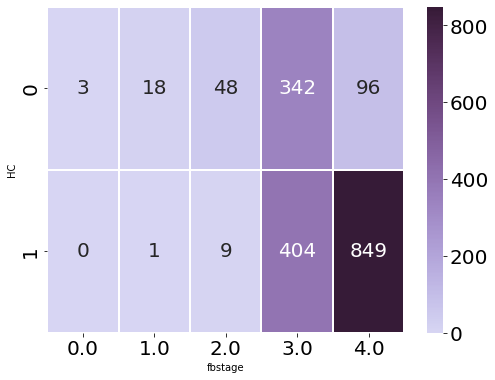

In [29]:
hc = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage = 'ward')

y_hc = hc.fit_predict(X_normal)

cross_table=pd.DataFrame()
cross_table['HC']=1-y_hc
cross_table['fbstage']=list(hist_gene_expression_selected['fibsg'])

ctable=pd.crosstab(cross_table['HC'],cross_table['fbstage'] )


pal = sns.cubehelix_palette(8, start=.5, rot=-.2, as_cmap=True)

sns.heatmap(ctable, linewidth=1, cmap=pal, cbar= True, annot=True, fmt='g', annot_kws={"size": 20})

### Example showing how to get results from Figure 2B

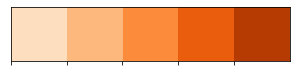

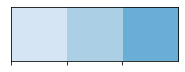

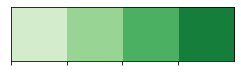

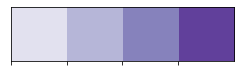

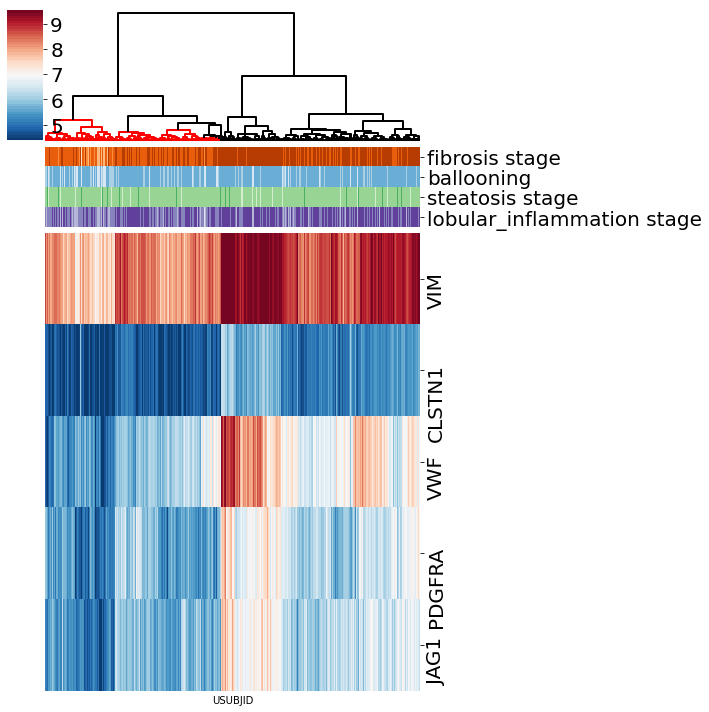

In [30]:
lut = dict(zip(set(hist_gene_expression_selected['fibsg']), 
               sns.color_palette("Oranges", len(set(hist_gene_expression_selected['fibsg'])))))
col_colors_fibrosis = hist_gene_expression_selected['fibsg'].map(lut)
col_colors_fibrosis = pd.DataFrame(col_colors_fibrosis)
col_colors_fibrosis.columns=['fibrosis stage']
col_colors_fibrosis.index=hist_gene_expression_selected['USUBJID']
sns.palplot(sns.color_palette(list(lut.values())))

lut_ballooning = dict(zip(set(hist_gene_expression_selected['ballooning']),
                          sns.color_palette("Blues", len(set(hist_gene_expression_selected['fibsg'])))))
col_colors_ballooning = hist_gene_expression_selected['ballooning'].map(lut_ballooning)
col_colors_ballooning = pd.DataFrame(col_colors_ballooning)
col_colors_ballooning.columns=['ballooning']
col_colors_ballooning.index=hist_gene_expression_selected['USUBJID']
sns.palplot(sns.color_palette(list(lut_ballooning.values())))

lut_steatosis = dict(zip(set(hist_gene_expression_selected['steatosis']), 
               sns.color_palette("Greens", len(set(hist_gene_expression_selected['steatosis'])))))
col_colors_steatosis = hist_gene_expression_selected['steatosis'].map(lut_steatosis)
col_colors_steatosis = pd.DataFrame(col_colors_steatosis)
col_colors_steatosis.columns=['steatosis stage']
col_colors_steatosis.index=hist_gene_expression_selected['USUBJID']
sns.palplot(sns.color_palette(list(lut_steatosis.values())))


lut_lobular = dict(zip(set(hist_gene_expression_selected['lobular_inflammation']), 
               sns.color_palette("Purples", len(set(hist_gene_expression_selected['lobular_inflammation'])))))
col_colors_lobular = hist_gene_expression_selected['lobular_inflammation'].map(lut_lobular)
col_colors_lobular = pd.DataFrame(col_colors_lobular)
col_colors_lobular.columns=['lobular_inflammation stage']
col_colors_lobular.index=hist_gene_expression_selected['USUBJID']
sns.palplot(sns.color_palette(list(lut_lobular.values())))


col_colors = pd.concat([col_colors_fibrosis,col_colors_ballooning, col_colors_steatosis, 
                        col_colors_lobular],axis=1)

gene_expression_clust= pd.DataFrame(hist_gene_expression_selected[gene_selected].values, columns= gene_selected,
                                    index=hist_gene_expression_selected['USUBJID'])


pal = sns.diverging_palette(255, 15, sep=10, n=256)
pal = sns.color_palette("RdBu_r",50)
gene_expression_clust_t=gene_expression_clust.transpose()
g= sns.clustermap(gene_expression_clust_t,  col_cluster=True,dendrogram_ratio=(.1, .2),
                   method='ward', metric='euclidean',  cmap=pal,  annot_kws={"size": 20},
                 robust=True, col_colors = col_colors, xticklabels=False,yticklabels=True,tree_kws={'colors':[(1,0,0,1)]*820+[(0,0,0,1)]*1770}) 
#for a in g.ax_row_dendrogram.collections:
#    a.set_linewidth(1)
for a in g.ax_col_dendrogram.collections:
    a.set_linewidth(2)  
g.ax_row_dendrogram.set_visible(False)

sns.set(font_scale=0.6)
plt.savefig('fb_stage.png', dpi=300)



In [31]:
#to do: not completed

class Graphical_Lasso_integrative_network:
    """
    Graphical Lasso for building an adjacency matrix for selected HIFs and Genes
    HIF_set :list of HIFs of interest
    gene_set= list of selected genes (intersection of correlated genes to HIFs of interest)
    """
    def __init__(self, df_HIF:pd.DataFrame, df_GE:pd.DataFrame, HIF_set, gene_set):
        self.df_HIF=df_HIF.copy()
        self.df_GE=df_GE.copy()
        self.hif=HIF_set
        self.gene_exp=gene_set
    #         if gene_set:
    #             self.gene_exp=self.gene_exp[gene_set]
    
    def gene_hist_intersection(self, time):
        hist_data_time=histology_data[histology_data['analysis_visit']==time]

        hist_data_filtered=hist_data_time.dropna(axis=0)
    
        analysis_col_MM2='AREA PROP [[BILE DUCT] OVER [TISSUE]] IN [TISSUE]_HE'
        hist_data_filtered=hist_data_filtered.loc[hist_data_filtered.groupby(['usubjid'])[analysis_col_MM2].idxmax()]

        Stellar_new_bl=STELLAR[STELLAR['analysis_visit']=='Screening']
        Stellar_new_bl=Stellar_new_bl.loc[Stellar_new_bl.groupby(['usubjid'])[analysis_col_MM2].idxmax()]


        Stellar_new_w48=STELLAR[STELLAR['analysis_visit']=='Week 48']
        Stellar_new_w48=Stellar_new_w48.loc[Stellar_new_w48.groupby(['usubjid'])[analysis_col_MM2].idxmax()]

        ### intersection of Stellar for analysis_col with BL GE
        Stellar_filtered_bl= Stellar_new_bl.dropna(subset=analysis_col)
        gene_expression_stellar_before= gene_expression_stellar[gene_expression_stellar.VISIT== 'Screening']


        #samples with both hist and gene expression data (BL)
        Samples_Stellar_ge1= list(set(Stellar_filtered_bl['usubjid']) & set(gene_expression_stellar_before['USUBJID']))

        Stellar_all1 = Stellar_filtered_bl[Stellar_filtered_bl['usubjid'].isin(Samples_Stellar_ge1)][['usubjid']+ analysis_col] 
        Stellar_all1=Stellar_all1.rename(columns={"usubjid": "USUBJID"})
        gene_expression_analysis1 = gene_expression_stellar_before[gene_expression_stellar_before['USUBJID']
                                                                  .isin(Samples_Stellar_ge1)] 
        gene_expression_analysis1=gene_expression_analysis1[genes_selected]

        #rearranging stellar hist samples as in gene expression 
        hist_gene_BL=Stellar_all1.merge(gene_expression_analysis1, how='inner', on='USUBJID')
    
    
def gene_hist_intersection_time(histology_data, gene_expression_data, time): 
    
    
    hist_data_time=histology_data[histology_data['analysis_visit']==time]

    hist_data_filtered=hist_data_time.dropna(axis=0)
    
    analysis_col_MM2='AREA PROP [[BILE DUCT] OVER [TISSUE]] IN [TISSUE]_HE'
    hist_data_filtered=hist_data_filtered.loc[hist_data_filtered.groupby(['usubjid'])[analysis_col_MM2].idxmax()]
    
    
    gene_expression_time= gene_expression_data[gene_expression_data.VISIT== time]
    Samples_hist_ge= list(set(hist_data_filtered['usubjid']) & set(gene_expression_time['USUBJID']))

    gene_expression_analysis = gene_expression_time[gene_expression_time['USUBJID']
                                                          .isin(Samples_hist_ge)] 

    #rearranging stellar hist samples as in gene expression 
    hist_analysis=pd.DataFrame()
    for i, x in enumerate(gene_expression_analysis['USUBJID']):
        hist=hist_data_filtered[hist_data_filtered['usubjid']==x][HIF_set]
        
        hist_analysis=pd.concat([hist_analysis, hist])
        
    return gene_expression_analysis , hist_analysis    
    
    
    
analysis_col1 ='AREA PROP [[BILE DUCT] OVER [TISSUE]] IN [TISSUE]_TRICHROME' 
analysis_col2 = 'AREA PROP [[PORTAL INFLAMMATION] OVER [TISSUE]] IN [TISSUE]_HE'
analysis_col3='AREA PROP [[FIBROSIS] OVER [TISSUE]] IN [TISSUE]_TRICHROME'

HIF_set= [analysis_col1, analysis_col2, analysis_col3]

n=200
gene_set1 = pd.read_csv('data/gene_selected_new2_'+ analysis_col1+'.csv')
A= set(gene_set1['0'][0:n])
gene_set2 = pd.read_csv('data/gene_selected_new2_'+ analysis_col2+'.csv')
B= set(gene_set2['0'][0:n])
gene_set3= pd.read_csv('data/gene_selected_new2_'+ analysis_col3+'.csv')
C= set(gene_set3['0'][0:n])

genes_selected= list(set(gene_set1['0'][0:n]) & set(gene_set2['0'][0:n])& set(gene_set3['0'][0:n]))

'''Integrative network with three features'''


analysis_col1 = 'AREA PROP [[BILE DUCT] OVER [TISSUE]] IN [TISSUE]_TRICHROME'
analysis_col2 = 'AREA PROP [[PORTAL INFLAMMATION] OVER [TISSUE]] IN [TISSUE]_HE'
analysis_col3= 'AREA PROP [[FIBROSIS] OVER [TISSUE]] IN [TISSUE]_TRICHROME'


analysis_col=[analysis_col1, analysis_col2, analysis_col3]

#analysis_col1_MM2='AREA (MM2) OF [BILE DUCT] IN [TISSUE]_HE'
analysis_col_MM2='AREA (MM2) OF [PORTAL INFLAMMATION] IN [TISSUE]_HE'

genes_selected.append('USUBJID')

STELLAR=STELLAR_new_concat

Stellar_new_bl=STELLAR[STELLAR['analysis_visit']=='Screening']
Stellar_new_bl=Stellar_new_bl.loc[Stellar_new_bl.groupby(['usubjid'])[analysis_col_MM2].idxmax()]


Stellar_new_w48=STELLAR[STELLAR['analysis_visit']=='Week 48']
Stellar_new_w48=Stellar_new_w48.loc[Stellar_new_w48.groupby(['usubjid'])[analysis_col_MM2].idxmax()]

### intersection of Stellar for analysis_col with BL GE
Stellar_filtered_bl= Stellar_new_bl.dropna(subset=analysis_col)
gene_expression_stellar_before= gene_expression_stellar[gene_expression_stellar.VISIT== 'Screening']


#samples with both hist and gene expression data (BL)
Samples_Stellar_ge1= list(set(Stellar_filtered_bl['usubjid']) & set(gene_expression_stellar_before['USUBJID']))

Stellar_all1 = Stellar_filtered_bl[Stellar_filtered_bl['usubjid'].isin(Samples_Stellar_ge1)][['usubjid']+ analysis_col] 
Stellar_all1=Stellar_all1.rename(columns={"usubjid": "USUBJID"})
gene_expression_analysis1 = gene_expression_stellar_before[gene_expression_stellar_before['USUBJID']
                                                          .isin(Samples_Stellar_ge1)] 
gene_expression_analysis1=gene_expression_analysis1[genes_selected]

#rearranging stellar hist samples as in gene expression 
hist_gene_BL=Stellar_all1.merge(gene_expression_analysis1, how='inner', on='USUBJID')
    
    
    
### intersection of Stellar for analysis_col with W48 GE
Stellar_filtered_w48= Stellar_new_w48.dropna(subset=analysis_col)
gene_expression_stellar_after= gene_expression_stellar[gene_expression_stellar.VISIT== 'Week 48']


#samples with both hist and gene expression data (W48)
Samples_Stellar_ge2= list(set(Stellar_filtered_w48['usubjid']) & set(gene_expression_stellar_after['USUBJID']))

Stellar_all2 = Stellar_filtered_w48[Stellar_filtered_w48['usubjid'].isin(Samples_Stellar_ge2)][['usubjid']+ analysis_col] 
Stellar_all2=Stellar_all2.rename(columns={"usubjid": "USUBJID"})
gene_expression_analysis2 = gene_expression_stellar_after[gene_expression_stellar_after['USUBJID']
                                                          .isin(Samples_Stellar_ge2)] 

gene_expression_analysis2=gene_expression_analysis2[genes_selected]
#rearranging stellar hist samples as in gene expression 
hist_gene_W48=Stellar_all2.merge(gene_expression_analysis2, how='inner', on='USUBJID')
    


gene_expression_analysis=[]
hist_gene_expression_selected=[]
hist_gene_expression_selected= pd.concat([hist_gene_BL, hist_gene_W48])   
hist_gene_expression_selected=hist_gene_expression_selected.drop(['USUBJID'], axis=1)



feature_selected= hist_gene_expression_selected.columns


pd.DataFrame(hist_gene_expression_selected).to_csv('hist_gene_expression_selected_new2.csv', index=False)

pd.DataFrame(feature_selected).to_csv('feature_selected_hist_expression_new2.csv', index=False) 

/home/pathai/.conda/envs/clin_acc4/lib/python3.6/site-packages/sklearn/covariance/_graph_lasso.py:229: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.0179466035147, tolerance: 0.3536243066648413
  check_random_state(None), False)
/home/pathai/.conda/envs/clin_acc4/lib/python3.6/site-packages/sklearn/covariance/_graph_lasso.py:229: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02569650544569413, tolerance: 0.014101737405626617
  check_random_state(None), False)
/home/pathai/.conda/envs/clin_acc4/lib/python3.6/site-packages/sklearn/covariance/_graph_lasso.py:229: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05001099020245192, tolerance: 0.009767962009158321
  check_random_state(None), False)
/home/pathai/.conda/envs/clin_acc4/lib/python3.6/site-packages/sklearn/covariance/_graph_l

831.0


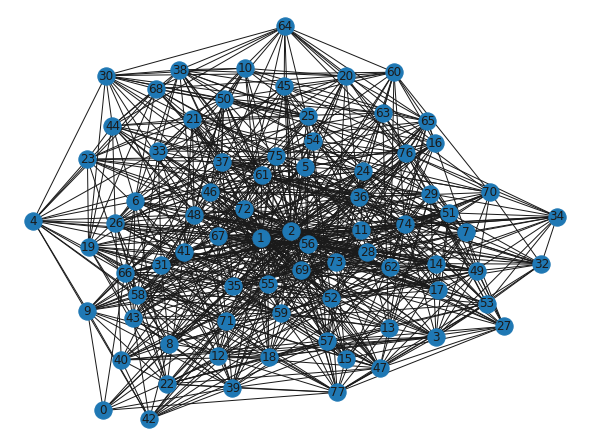

In [32]:
#Graphical Lasso for building an adjacency matrix for selected HIFs and Genes

gene_Cov=empirical_covariance(hist_gene_expression_selected)
gene_Cov_glasso=graphical_lasso(gene_Cov, alpha=0.035, max_iter=200)

gene_Precision=gene_Cov_glasso[1]
n=np.shape(hist_gene_expression_selected)[1]
Adj=np.zeros((n,n))
for i in range(n):
    for j in range(n):
        if (abs(gene_Precision[i,j])>0.0000001) & (i<j):
            Adj[i,j]=1
Adj=Adj+np.transpose(Adj)
number_of_edges=np.sum(Adj)/2
print(number_of_edges)

# Visualization of integrated network
G=nx.from_numpy_matrix(Adj)
nx.draw(G, with_labels = True) 

In [33]:
dict_Adj=dict()
for i,f in enumerate(hist_gene_expression_selected.columns):
    dict_Adj[f]=Adj[i,]
    
df_Adj=pd.DataFrame(dict_Adj)  
df_Adj.insert(0,'',hist_gene_expression_selected.columns)
df_Adj.to_csv('Adjacency_martix_new_features.csv', index=False)

In [34]:
node_weights=Adj[0,]+2*Adj[1,]
node_weights[0]=1
node_weights[1]=2
node_weights=pd.DataFrame(node_weights, columns=['weights'])
node_weights.insert(0, 'nodes', hist_gene_expression_selected.columns)
node_weights.to_csv('node_weights_new_features1.csv', index=False)

In [35]:
node_weights[node_weights.weights==3]

,nodes,weights
2,AREA PROP [[FIBROSIS] OVER [TISSUE]] IN [TISSU...,3.0
9,PDGFRA,3.0
35,CDH6,3.0
39,VIM,3.0
66,JAG1,3.0
71,VWF,3.0
77,CLSTN1,3.0


In [36]:
node_weights= Adj[0,]+2*Adj[1,]+4*Adj[2,]
node_weights[0]=1
node_weights[1]=2

node_weights[node_weights==3]=4
node_weights[node_weights==5]=4
node_weights[node_weights==6]=4
node_weights[node_weights==7]=5

node_weights[2]=3

node_weights=pd.DataFrame(node_weights, columns=['weights'])
node_weights.insert(0, 'Id', hist_gene_expression_selected.columns)
node_weights.to_csv('node_weights_new_features2.csv', index=False)

In [37]:
def forest_plot(features,results_table,model_string='CoxModel',color='k',offset=0,fig=None,ax=None,factor=1):
    '''
    Draw a forest plot for some features
    :param features: list of features to pull from index of results table
    :param results_table: pandas data frame with the following columns:
                "model_string"+_HR,"model_string"+_ci_low,"model_string"+_ci_high
    :return: fig,ax handle to figure
    '''
    # format the data
    hazards = results_table.loc[gene_selected,'hazards']
    ci_low = results_table.loc[gene_selected,'ci_low']
    ci_high = results_table.loc[gene_selected, 'ci_high']
    errors = np.stack([hazards - ci_low, ci_high - hazards]).reshape(2, -1)
    # draw plot
    if fig == None:
        fig, ax = plt.subplots(1)
    ax.errorbar(hazards, np.linspace(0, len(hazards)*factor - 1, len(hazards))+offset, xerr=errors, marker='.', ms=14, ls='',
                capsize=10, color=color)
    plt.plot([0, 0], [-0.5, len(hazards) + 0.5], 'k--')
    # format the plot
    ax.set_ylim([-0.5, len(hazards)*factor - 0.5])
    ax.set_xlim([0, 6])
    ax.set_yticks(np.linspace(0, len(hazards)*factor - 1, len(hazards)))
    ax.set_yticklabels(features)
    plt.xlabel('log(HR) (95% CI)')
    fig.set_dpi(150)
    return fig, ax

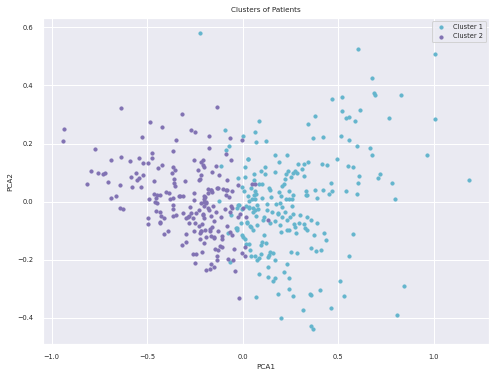

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
           9.32 <0.005      8.78

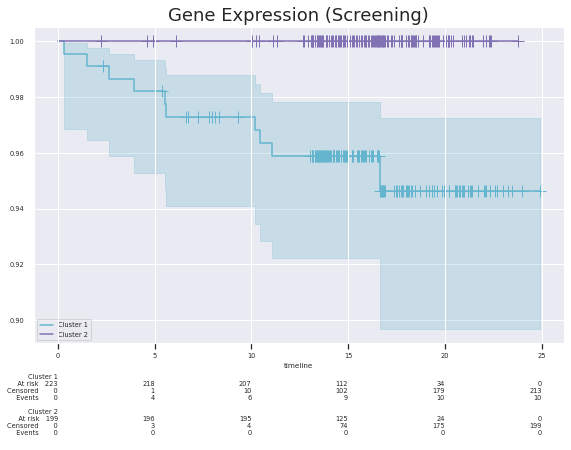

In [38]:
analysis_col1 = 'AREA PROP [[BILE DUCT] OVER [TISSUE]] IN [TISSUE]_TRICHROME'
analysis_col2 = 'AREA PROP [[PORTAL INFLAMMATION] OVER [TISSUE]] IN [TISSUE]_HE'
analysis_col3= 'AREA PROP [[FIBROSIS] OVER [TISSUE]] IN [TISSUE]_TRICHROME'
analysis_col_MM2='AREA (MM2) OF [PORTAL INFLAMMATION] IN [TISSUE]_HE'

gene_selected= ['VIM', 'PDGFRA', 'CLSTN1', 'JAG1', 'VWF']

Stellar_data= STELLAR_new_concat[STELLAR_new_concat['PartnerGroupName_x'].str.contains('Stellar4')]
Stellar_data= Stellar_data[Stellar_data.analysis_visit=='Screening']

analysis_col=['surv_col', 'event_col', analysis_col1, analysis_col2, analysis_col3]

Stellar_filtered= Stellar_data.dropna(subset=analysis_col)
gene_expression_stellar_before= gene_expression_stellar[gene_expression_stellar.VISIT== 'Screening']


Samples_Stellar_ge= list(set(Stellar_filtered['usubjid']) & set(gene_expression_stellar_before['USUBJID']))
gene_expression_analysis = gene_expression_stellar_before[gene_expression_stellar_before['USUBJID'].isin(Samples_Stellar_ge)] 


analysis_col=['surv_col', 'event_col', analysis_col1, analysis_col2, analysis_col3]
Stellar_filtered= Stellar_data.dropna(subset=analysis_col)
gene_expression_stellar_before= gene_expression_stellar[gene_expression_stellar.VISIT== 'Screening']
Stellar_filtered=Stellar_filtered.rename(columns={"usubjid": "USUBJID"})
Stellar_filtered=Stellar_filtered.loc[Stellar_filtered.groupby(['USUBJID'])[analysis_col_MM2].idxmax()]


hist_gene_expression_selected=gene_expression_stellar_before.merge(Stellar_filtered, how='inner', on='USUBJID')
hist_gene_expression_selected= hist_gene_expression_selected.dropna(subset=["USUBJID"])
hist_gene_expression_selected=hist_gene_expression_selected.filter(items=gene_selected+analysis_col)


hist_gene_expression_selected['event_col']=1-hist_gene_expression_selected['event_col']
hist_gene_expression_selected=hist_gene_expression_selected.rename(columns={'surv_col': 'time'})
hist_gene_expression_selected=hist_gene_expression_selected.rename(columns={'event_col': 'event'})



X= hist_gene_expression_selected[gene_selected]
X= hist_gene_expression_selected[gene_selected+[ analysis_col1, analysis_col2, analysis_col3]]


#normalizing mixed feature matrix
x = X.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
standard_scaler= preprocessing.StandardScaler()
x_scaled = min_max_scaler.fit_transform(x)

# x -> not nomalizing
# x-scale -> normalizing
X_normal = pd.DataFrame(x_scaled, columns=X.columns, index=X.index )
X=X_normal

# Using the dendrogram to find the optimal number of clusters
#import scipy.cluster.hierarchy as sch
#dendrogram = sch.dendrogram(sch.linkage(X, method = 'ward'))

#plt.title('Dendrogram')
#plt.xlabel('Patients')
#plt.ylabel('Euclidean distances')
#sch.set_link_color_palette(['m', 'c'])
#plt.show()

# Training the Hierarchical Clustering model on the dataset
hc = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(X)

# Visualising the clusters
pca = PCA(n_components = 2)

x_pca= pca.fit_transform(X)
plt.scatter(x_pca[y_hc == 0,0], x_pca[y_hc == 0,1], s = 10, c = 'c', label = 'Cluster 1')
plt.scatter(x_pca[y_hc == 1,0], x_pca[y_hc == 1,1], s = 10, c = 'm', label = 'Cluster 2')



plt.title('Clusters of Patients')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.show()
plt.rc('axes', titlesize=20)

i1 = (y_hc == 0)      
i2 = (y_hc == 1)     


## fit the model for 1st cohort
kmf1 = KaplanMeierFitter() 
kmf1.fit(np.array(hist_gene_expression_selected['time'])[i1], np.array(hist_gene_expression_selected['event'])[i1], label='Cluster 1')
ax = kmf1.plot(ci_show=True, show_censors=True, color='c')

## fit the model for 2nd cohort
kmf2 = KaplanMeierFitter() 
kmf2.fit(np.array(hist_gene_expression_selected['time'])[i2], np.array(hist_gene_expression_selected['event'])[i2], label='Cluster 2')
kmf2.plot(ax=ax, ci_show=True, show_censors=True, color='m')


add_at_risk_counts(kmf1, kmf2, ax=ax)

#logrank_test
results=logrank_test(np.array(hist_gene_expression_selected['time'])[i1],np.array(hist_gene_expression_selected['time'])[i2],
event_observed_A=np.array(hist_gene_expression_selected['event'])[i1], event_observed_B=np.array(hist_gene_expression_selected['event'])[i2])
results.print_summary()
plt.title('Gene Expression (Screening)', fontsize=18)
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.rc( 'legend', fontsize=18)
plt.rc( 'axes', labelsize=18)

plt.show()

# cph_table=dict()
# for i,g in enumerate(gene_selected):
    
#     cph = CoxPHFitter()
#     cph.fit(X[['event','time', g]], duration_col='time', event_col='event')
#     hazards= cph.params_[0]
#     ci_low = cph.confidence_intervals_['95% lower-bound'][0]
#     ci_high = cph.confidence_intervals_['95% upper-bound'][0]
#     cph_table[g]= [hazards, ci_low, ci_high]
    
# gene_univariate_table=pd.DataFrame.from_dict(cph_table, orient='index', columns=['hazards', 'ci_low', 'ci_high'])
# x = np.array(range(len(gene_selected)))
# fig,ax = forest_plot(gene_selected,gene_univariate_table,color='k')
# plt.xticks([0,1])
# plt.xlim([-0.5,2])


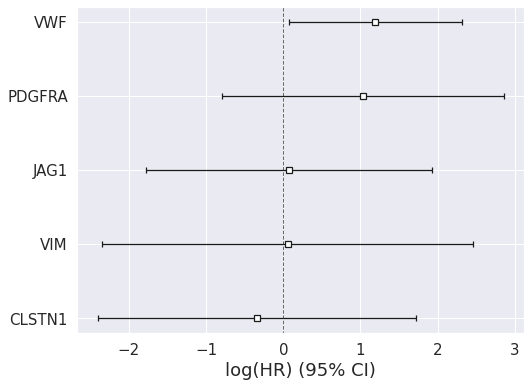

<lifelines.CoxPHFitter: fitted with 422 total observations, 412 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 422
number of events observed = 10
   partial log-likelihood = -50.12
         time fit was run = 2023-03-23 22:14:19 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
VIM         0.06       1.06       1.23            -2.35             2.46                 0.10                11.76
PDGFRA      1.03       2.80       0.93            -0.80             2.85                 0.45                17.36
CLSTN1     -0.34       0.71       1.05            -2.40             1.72                 0.09                 5.56
JAG1        0.07       1.07       0.95            -1.78             1.92                 0.17                 6.85
VWF         1.19       3.30       0.57             0.07             2.31                 1.08                10.10

              z    p   -log2(p)
covariate                      
VIM        0.05 0.96       0.06
PDGFRA     1.10 0.27       1.89
CLSTN1    -0.33 0.74       0.43
JAG1       0.07 0.94       0.09
VWF        2.09 0.04       4.77
---
Concordance = 0.85
Partial AIC = 110.25
log-likelihood ratio test = 18.27 on 5 df
-log2(p) of ll-ratio test = 8.57

In [39]:
cph = CoxPHFitter()
cph.fit(hist_gene_expression_selected[['event','time']+gene_selected], duration_col='time', event_col='event')
hazards= cph.params_[0]
ci_low = cph.confidence_intervals_['95% lower-bound'][0]
ci_high = cph.confidence_intervals_['95% upper-bound'][0]
#cph_table[g]= [hazards, ci_low, ci_high]
plt.title('')
cph.plot()
plt.show()
cph.print_summary()   

### Example showing how to generate one of STELLAR 4 survival curves from Figure 3C

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
           9.32 <0.005      8.78

0.002271394118588876


/home/pathai/.conda/envs/clin_acc4/lib/python3.6/site-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


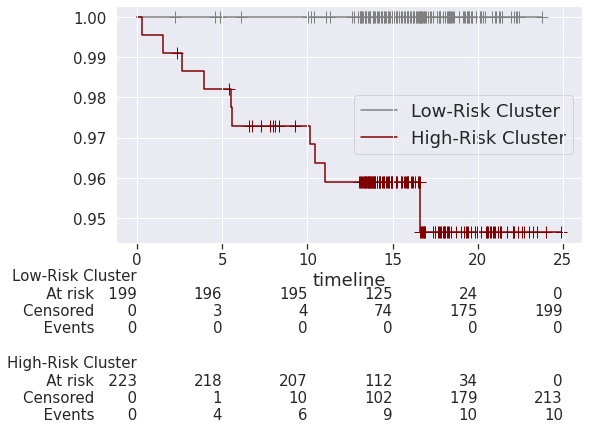

In [40]:
i1 = (y_hc == 1)      
i2 = (y_hc == 0)   

## fit the model for 1st cohort
kmf1 = KaplanMeierFitter() 
kmf1.fit(np.array(hist_gene_expression_selected['time'])[i1], np.array(hist_gene_expression_selected['event'])[i1], label='Low-Risk Cluster')
ax = kmf1.plot(ci_show=False, show_censors=True, color='gray')

## fit the model for 2nd cohort
kmf2 = KaplanMeierFitter() 
kmf2.fit(np.array(hist_gene_expression_selected['time'])[i2], np.array(hist_gene_expression_selected['event'])[i2], label='High-Risk Cluster')
kmf2.plot(ax=ax, ci_show=False, show_censors=True, color='maroon')



add_at_risk_counts(kmf1, kmf2, ax=ax)


results=logrank_test(np.array(hist_gene_expression_selected['time'])[i1],np.array(hist_gene_expression_selected['time'])[i2],
event_observed_A=np.array(hist_gene_expression_selected['event'])[i1], event_observed_B=np.array(hist_gene_expression_selected['event'])[i2])
results.print_summary()
print(results.p_value)  
plt.title('', fontsize=18)

plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.rc( 'legend', fontsize=18)
plt.rc( 'axes', labelsize=18)
plt.ylabel('Proportion Free of Progression to Cirrhosis', fontsize=18)
plt.rcParams["figure.figsize"] = [8,6]
plt.tight_layout(0.0001)
plt.savefig('hist_KM_stellar3.png', dpi=300, bbox_inches = 'tight')


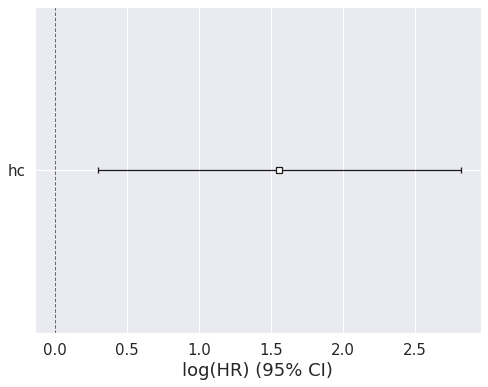

<lifelines.CoxPHFitter: fitted with 422 total observations, 412 right-censored observations>
             duration col = 'time'
                event col = 'event'
                penalizer = 0.01
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 422
number of events observed = 10
   partial log-likelihood = -55.75
         time fit was run = 2023-03-23 22:14:20 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
hc          1.56       4.75       0.64             0.30             2.82                 1.35                16.71

             z    p   -log2(p)
covariate                     
hc        2.43 0.02       6.03
---
Concordance = 0.74
Partial AIC = 113.49
log-likelihood ratio test = 7.02 on 1 df
-log2(p) of ll-ratio test = 6.96

In [41]:
HC_cox=hist_gene_expression_selected.drop(gene_selected+[analysis_col1,analysis_col2,analysis_col3], axis=1)
#HC_cox=hist_gene_expression_selected.drop(gene_selected, axis=1)
HC_cox.insert(2,'hc', 1-y_hc, True)

cph = CoxPHFitter(penalizer=0.01)
cph.fit(HC_cox, duration_col='time', event_col='event')
plt.title('')
cph.plot()
plt.show()
cph.print_summary()

In [42]:
HC_cox.hc.sum()/len(HC_cox)

0.5284360189573459

In [43]:
HC_cox.time.mean()

15.880572613367299

In [44]:
HC_cox.event.sum()/len(HC_cox)

0.023696682464454975

In [45]:
len(HC_cox)

422

In [46]:
events = HC_cox['event'].astype(bool)
print(HC_cox.loc[events, 'hc'].var())
print(HC_cox.loc[~events, 'hc'].var())

0.0
0.2503189001488201


In [47]:
hist_gene_expression_selected

,VIM,PDGFRA,CLSTN1,JAG1,VWF,time,event,AREA PROP [[BILE DUCT] OVER [TISSUE]] IN [TISSUE]_TRICHROME,AREA PROP [[PORTAL INFLAMMATION] OVER [TISSUE]] IN [TISSUE]_HE,AREA PROP [[FIBROSIS] OVER [TISSUE]] IN [TISSUE]_TRICHROME
0,8.150550,5.502813,4.519171,5.859419,5.815802,18.431211,0.0,0.995118,6.712110,14.231620
1,8.878509,6.799114,5.499200,6.270009,7.247930,16.722793,0.0,1.924951,9.270344,19.056438
2,8.280906,5.979003,4.884935,6.164976,5.864404,19.154004,0.0,0.406032,4.855484,7.150870
3,9.394482,7.102714,5.757997,7.174874,7.558708,15.671458,0.0,2.902623,27.407607,37.968996
4,9.118907,6.713280,5.377010,6.681411,6.197713,16.394251,0.0,1.819191,11.539438,20.927799
...,...,...,...,...,...,...,...,...,...,...
417,9.352604,7.112746,5.885546,6.997790,8.539201,15.507187,0.0,2.749472,15.765664,27.707925
418,9.275075,7.121570,5.476556,6.927557,7.432112,15.474333,0.0,1.011489,7.599833,24.647280
419,8.899672,6.404452,5.169679,6.145884,6.948140,16.624230,0.0,0.165477,5.932503,2.480875
420,9.004975,6.460011,5.215088,6.785873,7.118228,16.164271,0.0,1.250537,6.171920,27.083732


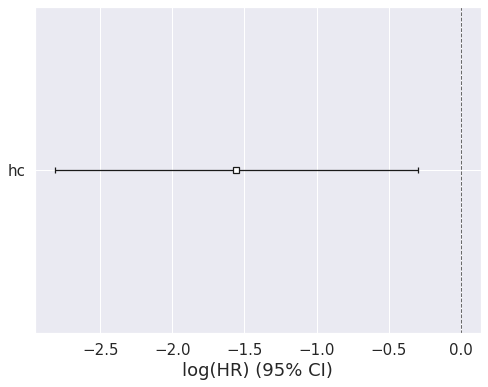

<lifelines.CoxPHFitter: fitted with 422 total observations, 412 right-censored observations>
             duration col = 'time'
                event col = 'event'
                penalizer = 0.01
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 422
number of events observed = 10
   partial log-likelihood = -55.75
         time fit was run = 2023-03-23 22:14:21 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
hc         -1.56       0.21       0.64            -2.82            -0.30                 0.06                 0.74

              z    p   -log2(p)
covariate                      
hc        -2.43 0.02       6.03
---
Concordance = 0.74
Partial AIC = 113.49
log-likelihood ratio test = 7.02 on 1 df
-log2(p) of ll-ratio test = 6.96

In [48]:
HC_cox=hist_gene_expression_selected.drop(gene_selected+[analysis_col1,analysis_col2,analysis_col3], axis=1)
#HC_cox=hist_gene_expression_selected.drop(gene_selected, axis=1)
HC_cox.insert(2,'hc', y_hc, True)

cph = CoxPHFitter(penalizer=0.01)
cph.fit(HC_cox, duration_col='time', event_col='event')
plt.title('')
cph.plot()
plt.show()
cph.print_summary()

### Example showing how to generate Figure 3B

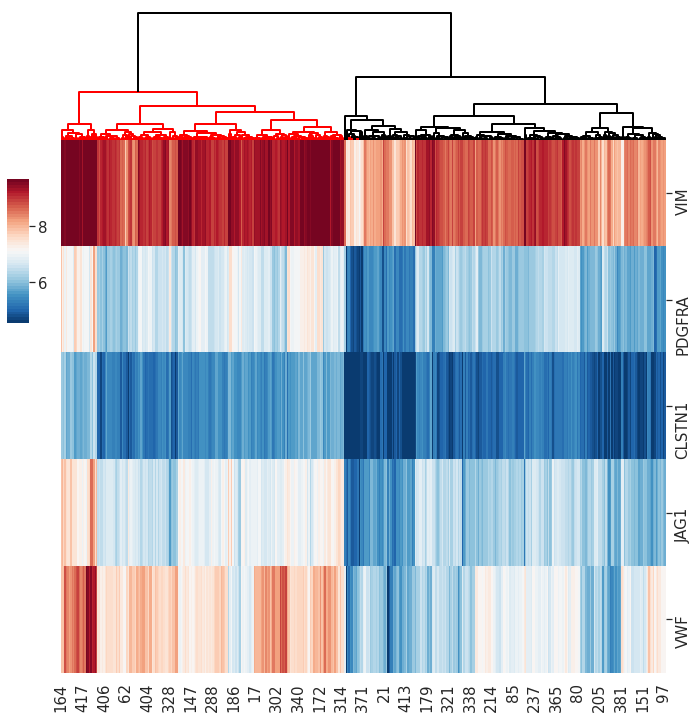

In [49]:
analysis_col1 = 'AREA PROP [[BILE DUCT] OVER [TISSUE]] IN [TISSUE]_TRICHROME'
analysis_col2 = 'AREA PROP [[PORTAL INFLAMMATION] OVER [TISSUE]] IN [TISSUE]_HE'
analysis_col3= 'AREA PROP [[FIBROSIS] OVER [TISSUE]] IN [TISSUE]_TRICHROME'
analysis_col_MM2='AREA (MM2) OF [PORTAL INFLAMMATION] IN [TISSUE]_HE'

gene_selected= ['VIM', 'PDGFRA', 'CLSTN1', 'JAG1', 'VWF']
Stellar_data= STELLAR_new_concat[STELLAR_new_concat['PartnerGroupName_x'].str.contains('Stellar4')]
Stellar_data= Stellar_data[Stellar_data.analysis_visit=='Screening']

analysis_col=['surv_col', 'event_col', analysis_col1, analysis_col2, analysis_col3]

Stellar_filtered= Stellar_data.dropna(subset=analysis_col)
gene_expression_stellar_before= gene_expression_stellar[gene_expression_stellar.VISIT== 'Screening']



Samples_Stellar_ge= list(set(Stellar_filtered['usubjid']) & set(gene_expression_stellar_before['USUBJID']))


gene_expression_analysis = gene_expression_stellar_before[gene_expression_stellar_before['USUBJID'].isin(Samples_Stellar_ge)] 


analysis_col=['surv_col', 'event_col', analysis_col1, analysis_col2, analysis_col3]
Stellar_filtered= Stellar_data.dropna(subset=analysis_col)
gene_expression_stellar_before= gene_expression_stellar[gene_expression_stellar.VISIT== 'Screening']
Stellar_filtered=Stellar_filtered.rename(columns={"usubjid": "USUBJID"})
Stellar_filtered=Stellar_filtered.loc[Stellar_filtered.groupby(['USUBJID'])[analysis_col_MM2].idxmax()]

hist_gene_expression_selected=gene_expression_stellar_before.merge(Stellar_filtered, how='inner', on='USUBJID')
hist_gene_expression_selected= hist_gene_expression_selected.dropna(subset=["USUBJID"])
hist_gene_expression_selected=hist_gene_expression_selected.filter(items=gene_selected+analysis_col)


hist_gene_expression_selected['event_col']=1-hist_gene_expression_selected['event_col']
hist_gene_expression_selected=hist_gene_expression_selected.rename(columns={'surv_col': 'time'})
hist_gene_expression_selected=hist_gene_expression_selected.rename(columns={'event_col': 'event'})


X= hist_gene_expression_selected[gene_selected]
X=X.rename(columns={"AREA PROP [[BILE DUCT] OVER [TISSUE]] IN [TISSUE]_TRICHROME": "Bile Duct",
        "AREA PROP [[PORTAL INFLAMMATION] OVER [TISSUE]] IN [TISSUE]_HE" : "Portal Inflammation",
         "AREA PROP [[FIBROSIS] OVER [TISSUE]] IN [TISSUE]_TRICHROME":"Fibrosis"})


#normalizing mixed feature matrix
x = X.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
standard_scaler= preprocessing.StandardScaler()
x_scaled = standard_scaler.fit_transform(x)

# x -> not nomalizing
# x-scale -> normalizing
X_normal = pd.DataFrame(x_scaled, columns=X.columns, index=X.index )
gene_expression_clust=X



pal = sns.diverging_palette(255, 15, sep=10, n=256)
pal = sns.color_palette("RdBu_r",50)

g= sns.clustermap(gene_expression_clust.T,  col_cluster=True, row_cluster=False, dendrogram_ratio=(.1, .2),robust=True,
                   method='ward', metric='euclidean',  cmap=pal, cbar_pos=(.04, .55, .03, .2), annot_kws={"size": 20},tree_kws={'colors':[(1,0,0,1)]*200+[(0,0,0,1)]*1770})
#for a in g.ax_row_dendrogram.collections:
#    a.set_linewidth(1)
for a in g.ax_col_dendrogram.collections:
    a.set_linewidth(2)  
g.ax_row_dendrogram.set_visible(False)
sns.set(font_scale=2)
plt.savefig('heatmap_cluster_KM.png', dpi=300)

## Subset of Graph Based Analysis

In [50]:
## community detection algorithm 
analysis_col1 = 'AREA PROP [[BILE DUCT] OVER [TISSUE]] IN [TISSUE]_TRICHROME'
analysis_col2 = 'AREA PROP [[PORTAL INFLAMMATION] OVER [TISSUE]] IN [TISSUE]_HE'
analysis_col3= 'AREA PROP [[FIBROSIS] OVER [TISSUE]] IN [TISSUE]_TRICHROME'


n=800
gene_set1 = pd.read_csv('data/gene_selected_new2_'+ analysis_col1+'.csv')
A= set(gene_set1['0'][0:n])
gene_set2 = pd.read_csv('data/gene_selected_new2_'+ analysis_col2+'.csv')
B= set(gene_set2['0'][0:n])
gene_set3= pd.read_csv('data/gene_selected_new2_'+ analysis_col3+'.csv')
C= set(gene_set3['0'][0:n])
genes_selected= list(C)

gene_expression_selected=gene_expression_stellar[genes_selected]

Biogrid= pd.read_csv('data/BIOGRID-Homo_sapiens.csv')

substring= 'entrez gene'
Genes1=[]
Genes2=[]
for i in range(len(Biogrid)):
    gene1= re.search('locuslink:(.*)',Biogrid["Alt IDs Interactor A"][i]).group(1)
    gene2= re.search('locuslink:(.*)',Biogrid["Alt IDs Interactor B"][i]).group(1)
    if substring in gene1:
        gene1=re.search('(.*)\|entrez gene',gene1).group(1)
    if substring in gene2:
        gene2=re.search('(.*)\|entrez gene',gene2).group(1)    
        
    Genes1.append(gene1)
    Genes2.append(gene2)

#Biogrid interaction

g_biogrid= list(set(Genes1)|set(Genes2))

g_biogrid = pd.unique(g_biogrid)
g_list = list(set(g_biogrid) & set(genes_selected))

gene_selected_interaction1=[]
for i in range(np.shape(Genes1)[0]):
    if (Genes1[i] in g_list) & (Genes2[i] in g_list):
        g=[Genes1[i],Genes2[i]]
        if (Genes1[i] != Genes2[i]):
            gene_selected_interaction1.append(g)
            
gene_selected_interaction1= pd.DataFrame(gene_selected_interaction1, columns=  ['Source', 'Target']) 
            
# HPRD interaction         
hprd_interaction = pd.read_csv('data/HPRD_genes.csv', header=None)
g_hprd=list(set(hprd_interaction[0])| set(hprd_interaction[1]))
g_hprd = pd.unique(g_hprd)
g_list = list(set(g_hprd) & set(genes_selected))

gene_selected_interaction2=[]
for i in range(hprd_interaction.shape[0]):
    if (hprd_interaction[0][i] in g_list) & (hprd_interaction[1][i] in g_list):
        g=[hprd_interaction[0][i],hprd_interaction[1][i]]
        if (hprd_interaction[0][i] != hprd_interaction[1][i]):
            gene_selected_interaction2.append(g)

gene_selected_interaction2= pd.DataFrame(gene_selected_interaction2, columns=  ['Source', 'Target'])   

gene_selected_interaction=pd.concat([gene_selected_interaction1, gene_selected_interaction2])            
gene_selected_interaction= gene_selected_interaction.drop_duplicates()                      
          
g_interaction_list = np.unique([gene_selected_interaction['Source'], gene_selected_interaction['Target']] )       

gene_selected_interaction= pd.DataFrame(gene_selected_interaction, columns=  ['Source', 'Target'])
gene_selected_interaction.index=range(gene_selected_interaction.shape[0])       
         
        
g_hprd_biogrid_list = np.unique([gene_selected_interaction['Source'], gene_selected_interaction['Target']] )       


# correlation matrix
edge_weights=[]
for i in range(gene_selected_interaction.shape[0]):
    r,_  = st.pearsonr(gene_expression_selected[gene_selected_interaction['Source'][i]], 
                          gene_expression_selected[gene_selected_interaction['Target'][i]])
    affine_r=0.5*(1+r) 
    abs_r=abs(r)
    edge_weights.append(abs_r)
    
gene_selected_interaction['Weight']=edge_weights    

430 862


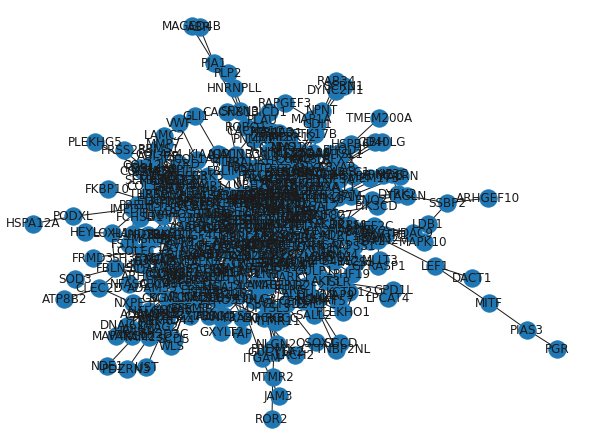

In [51]:
#make a graph from edge list
G=nx.Graph()
G.clear()
for i in range(gene_selected_interaction.shape[0]):
    G.add_edge(gene_selected_interaction['Source'][i],gene_selected_interaction['Target'][i], 
               weight=gene_selected_interaction['Weight'][i]) 
    
#find the largest connected component of network     
Gc =  max(nx.connected_components(G), key=len)
S = G.subgraph(Gc).copy() 

#visualization
nx.draw(S, with_labels = True)    

A = nx.adjacency_matrix(S)  #adjacenecy matrix
WAdj= A.todense()

print(len(S.nodes), len(S.edges))


#shortest path between nodes in graph

Dist=[]
for g1 in list(S.nodes):
    Dist_row=[]
    for g2 in list(S.nodes):
        Dist_ij= np.shape(nx.shortest_path(G, source=g1, target=g2))[0]-1
        Dist_row.append(Dist_ij)
    Dist.append(Dist_row) 
    
Dist= np.array(Dist) 

In [52]:
n=len(S.nodes)

def Compute_prob(i):
    a=[]
    for aa in (WAdj[:,i]/WAdj.sum(0)[0,i]).tolist():
        a.append(aa[0])
    return a
cprob_all=[]

for i in range(n):
    cprob=Compute_prob(i)
    cprob_all.append(cprob)
    
def Wass_rows(i1):
    Wdist_row=[]
    for i2 in range(n):
        if i2>i1:
            a=cprob_all[i1]
            b=cprob_all[i2]
            M= Dist.tolist()
            W_ij=ot.emd2(a,b,M)

        else:
             W_ij=0
        Wdist_row.append(W_ij)

    return i1, np.array(Wdist_row)   


In [53]:
print("Number of processors: ", mp.cpu_count())

pool = mp.Pool()                        
Wdist_i=pool.map(Wass_rows, range(n)) 
Wdist=dict()
for i in range(n):
    Wdist[Wdist_i[i][0]]=Wdist_i[i][1]

Wdist=np.matrix(pd.DataFrame.from_dict(Wdist, orient='index').sort_index(axis=0))
Wdists=Wdist+np.transpose(Wdist)
pd.DataFrame(Wdists).to_csv('wdist1500_BD_PI_FB_abs_r.csv', index=False)

Number of processors:  48


In [54]:
data_matrix = Wdists
n=25
model = AgglomerativeClustering(affinity='precomputed', n_clusters=n, linkage='complete').fit(data_matrix)
hclust=pd.DataFrame(model.labels_, columns=["clust"])
nodes_Id=pd.DataFrame(S.nodes, columns=['Id'])
nodes_Id['weights']=hclust
pd.DataFrame(nodes_Id).to_csv("CD_newfeatures_1500_nodes.csv",index=False, header=True)


edges_Id=pd.DataFrame(S.edges,columns=['Source', 'Target'])
pd.DataFrame(edges_Id).to_csv("CD_newfeatures_1500_edges.csv",index=False, header=True)

In [55]:
x=nodes_Id[nodes_Id['weights']==list(nodes_Id[nodes_Id['Id']=='JAG1']['weights'])[0]]
n_clusters=n
y=dict()
for i in range(n_clusters):
    y[i]=np.shape(nodes_Id[nodes_Id['weights']==i])[0]

In [56]:
y

{0: 62,
 1: 11,
 2: 12,
 3: 15,
 4: 29,
 5: 100,
 6: 19,
 7: 15,
 8: 9,
 9: 16,
 10: 44,
 11: 6,
 12: 3,
 13: 3,
 14: 9,
 15: 12,
 16: 19,
 17: 14,
 18: 7,
 19: 5,
 20: 4,
 21: 5,
 22: 3,
 23: 4,
 24: 4}